## Import Statements

In [6]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# Data Settings

In [7]:
DATA_PATH = Path(f"./1000-words-kept-data/")
NUMBER_OF_COMPONENTS = [10, 20, 30, 40, 50, 60]
METHODS = ["matrix_completed_svd", "svd", "truncated_svd", "pca"]

## KMeans & Agglomerative Clustering Overview

We performed clustering using two popular algorithms on dimensionality-reduced datasets:

- **KMeans Clustering**
- **Agglomerative Clustering**

These methods were applied to datasets reduced by various techniques including Matrix Completed SVD, SVD, Truncated SVD, and PCA, each with **(20, 30, 40, 50, 60) components**.

# Defining Function for Clustering and Visualizing

The function is made to be able to call multiple files.

Loads a dimensionality-reduced CSV file, performs KMeans and Agglomerative clustering,
visualizes the results, and returns silhouette scores for both clustering methods.

In [8]:
def cluster_and_visualize_from_df(df, method, components, n_clusters=6):
    """
    Perform clustering, visualization, and scoring on a reduced component DataFrame.

    Args:
        df (pd.DataFrame): Input dataframe with metadata + 60 components.
        method (str): Name of dimensionality reduction method for labeling.
        components (int): Number of components to use.
        n_clusters (int): Number of clusters.

    Returns:
        List[dict]: Silhouette score summary.
    """
    # Select component features
    feature_cols = [col for col in df.columns if col.startswith("SVD_") or col.startswith("PC")]
    reduced_cols = feature_cols[:components]
    df_reduced = df[reduced_cols + ['Sector']].copy()  # keep Sector for heatmaps

    X = df_reduced[reduced_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    df_reduced['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

    # Agglomerative clustering
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    df_reduced['Agglomerative_Cluster'] = agg.fit_predict(X_scaled)

    # Reduce to 2D for plotting
    if X_scaled.shape[1] > 2:
        X_2d = PCA(n_components=2).fit_transform(X_scaled)
    else:
        X_2d = X_scaled

    df_reduced['PC1'] = X_2d[:, 0]
    df_reduced['PC2'] = X_2d[:, 1]

    # Pretty label
    label = f"{method}_{components}_components"
    plot_title = label.replace("_", " ").title()

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"Clustering Analysis – {plot_title}", fontsize=16, y=0.95)

    sns.scatterplot(data=df_reduced, x='PC1', y='PC2', hue='KMeans_Cluster', style='Sector',
                    palette='tab10', s=70, ax=axes[0, 0])
    axes[0, 0].set_title("KMeans Clusters (2D PCA View)")

    sns.scatterplot(data=df_reduced, x='PC1', y='PC2', hue='Agglomerative_Cluster', style='Sector',
                    palette='tab10', s=70, ax=axes[0, 1])
    axes[0, 1].set_title("Agglomerative Clusters (2D PCA View)")

    # Heatmaps
    kmeans_ct = pd.crosstab(df_reduced['KMeans_Cluster'], df_reduced['Sector'])
    sns.heatmap(kmeans_ct, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=axes[1, 0])
    axes[1, 0].set_title("KMeans Cluster vs Sector")
    axes[1, 0].set_xlabel("Sector")
    axes[1, 0].set_ylabel("KMeans Cluster")
    axes[1, 0].tick_params(axis='x', rotation=45)

    agg_ct = pd.crosstab(df_reduced['Agglomerative_Cluster'], df_reduced['Sector'])
    sns.heatmap(agg_ct, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=axes[1, 1])
    axes[1, 1].set_title("Agglomerative Cluster vs Sector")
    axes[1, 1].set_xlabel("Sector")
    axes[1, 1].set_ylabel("Agglomerative Cluster")
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Silhouette Scores
    kmeans_sil = silhouette_score(X_scaled, df_reduced['KMeans_Cluster'])
    agg_sil = silhouette_score(X_scaled, df_reduced['Agglomerative_Cluster'])

    return [
        {
            "Dataset": plot_title,
            "Components": components,
            "Method": "KMeans",
            "Silhouette Score": kmeans_sil
        },
        {
            "Dataset": plot_title,
            "Components": components,
            "Method": "Agglomerative",
            "Silhouette Score": agg_sil
        }
    ]

## Visualizations and Results of K-Means and Agglomerative Clustering

For each dataset, the following visualizations were produced:

- **2D Scatterplots:**  Clusters projected onto the first two principal components (PC1 and PC2), with points colored by cluster assignment and shaped by true sector labels.  
  This helps visually assess how well the clusters separate different sectors.

- **Heatmaps (Cluster vs Sector):**  Confusion matrices comparing predicted clusters to true sector labels.  
  This shows how well each cluster corresponds to actual sectors and highlights cluster purity or mixing.

- **Silhouette Scores:**  Quantitative metric indicating the compactness and separation of clusters.  
  Scores were calculated for both KMeans and Agglomerative methods across datasets.

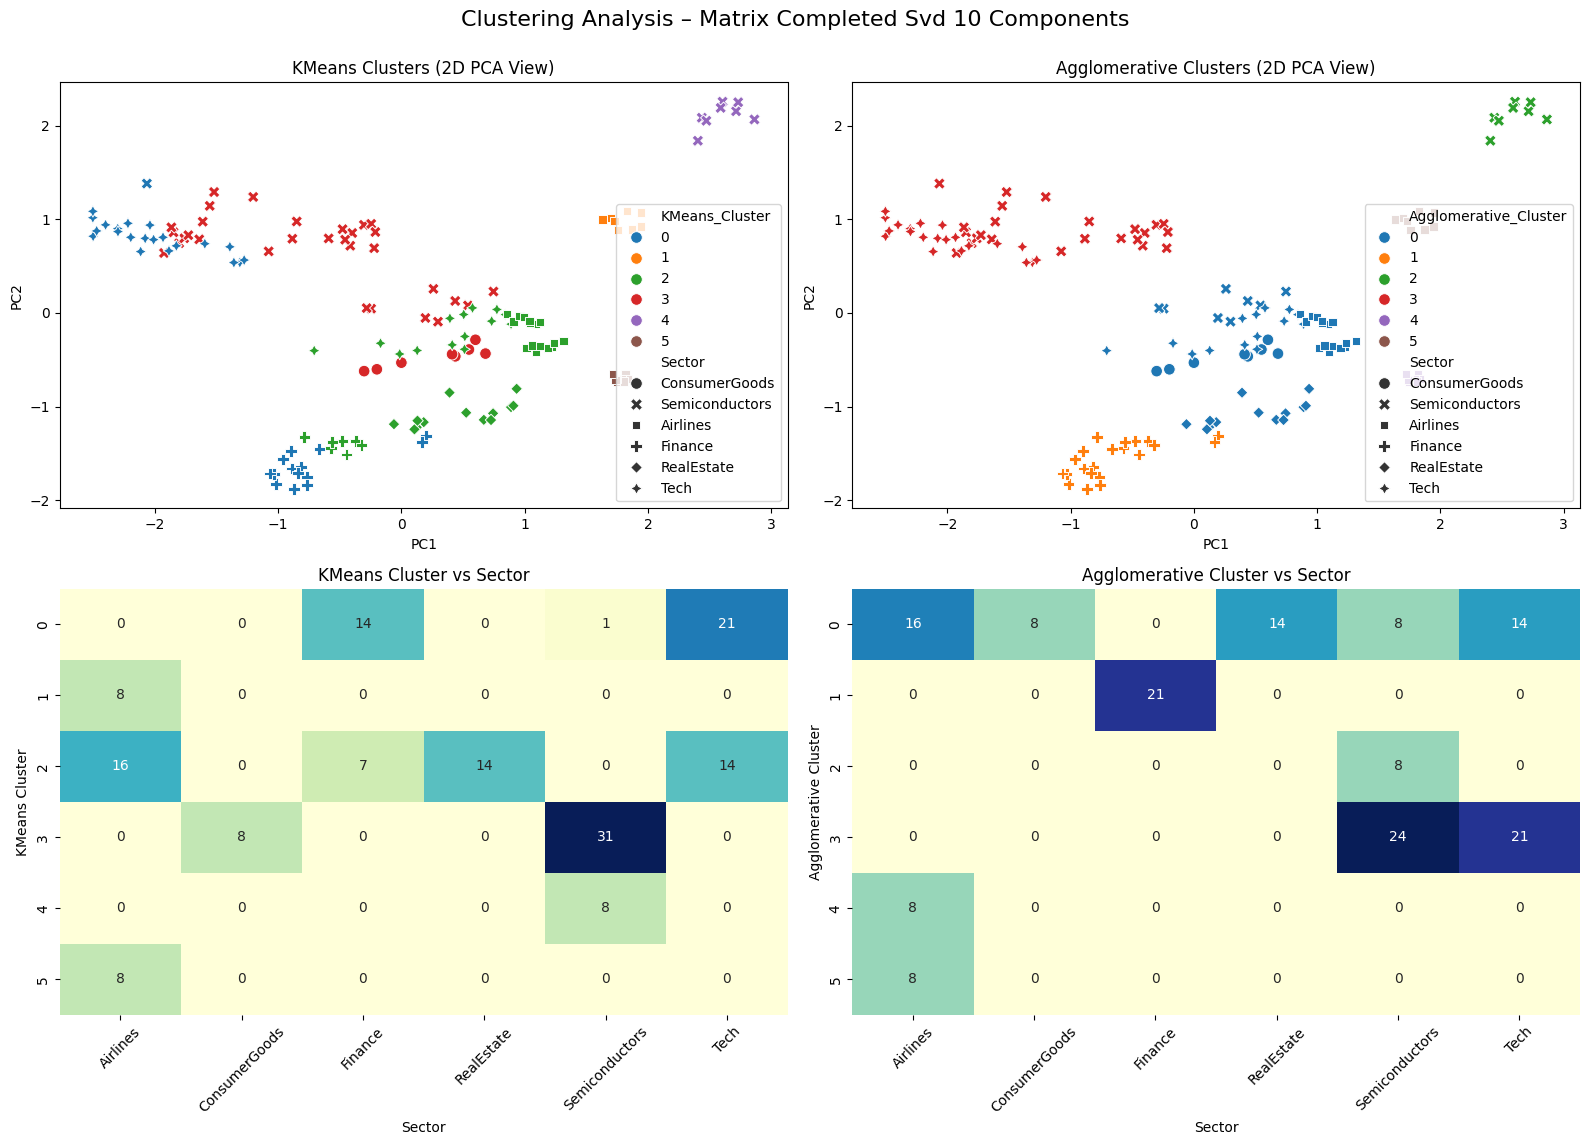

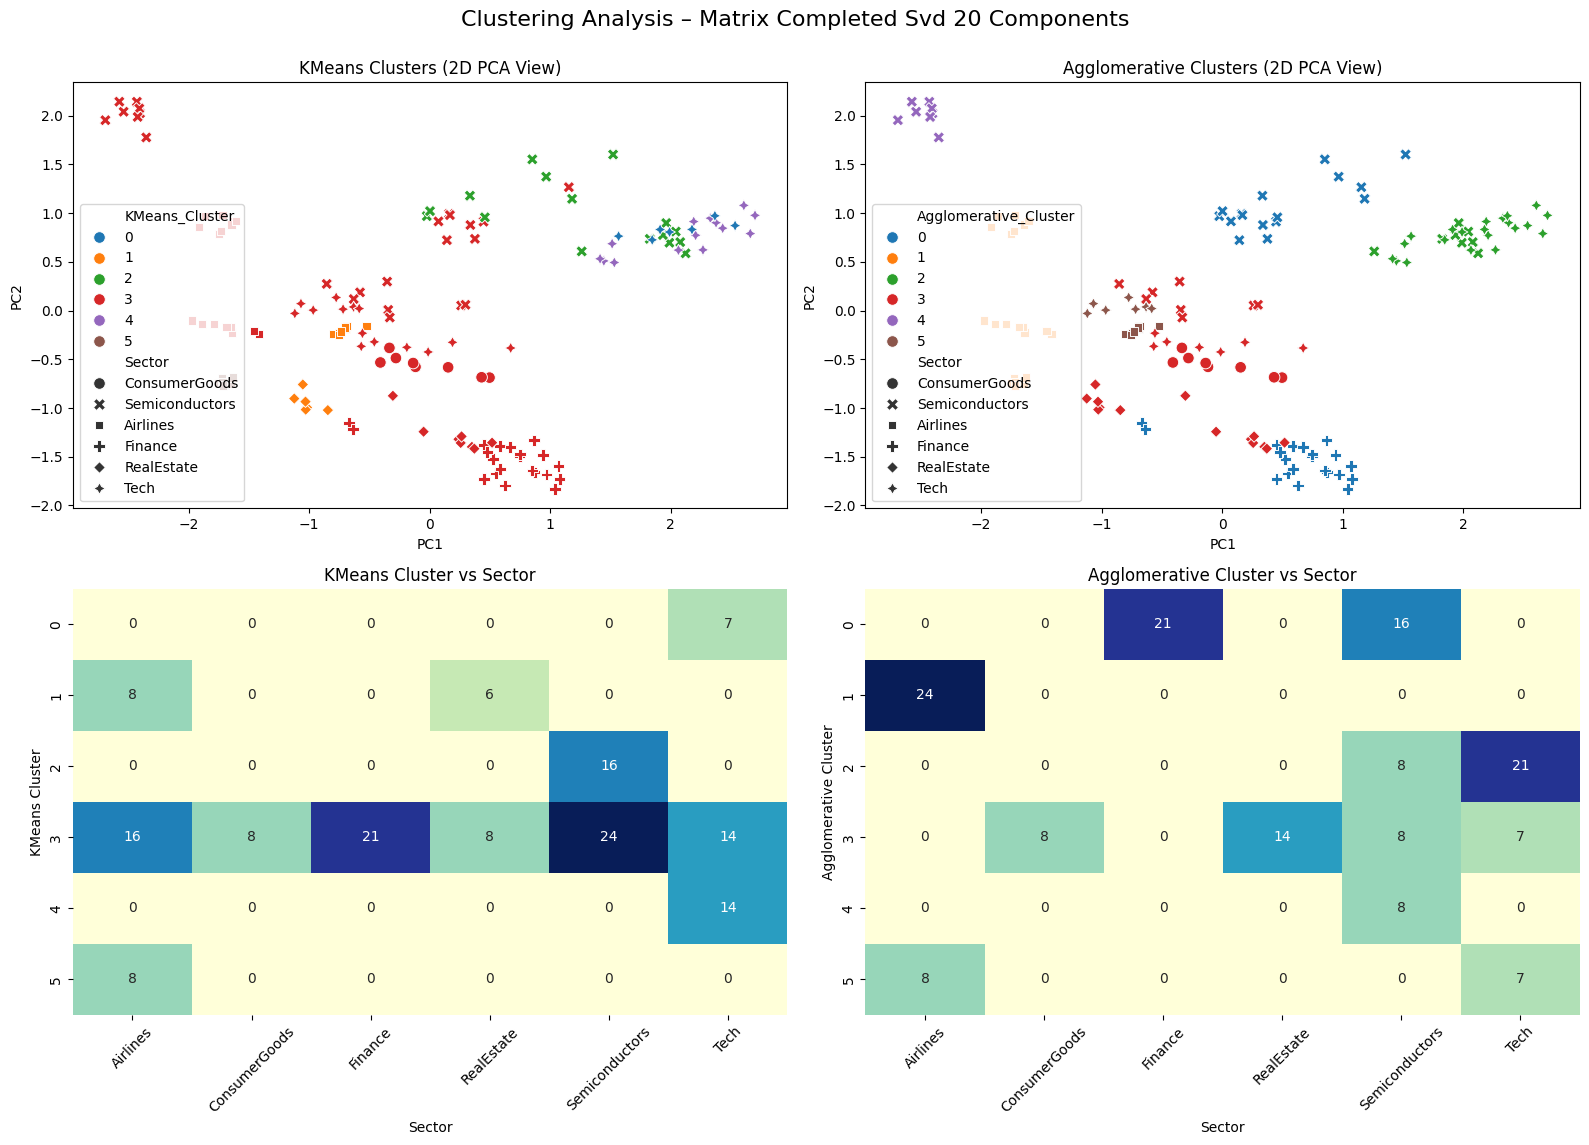

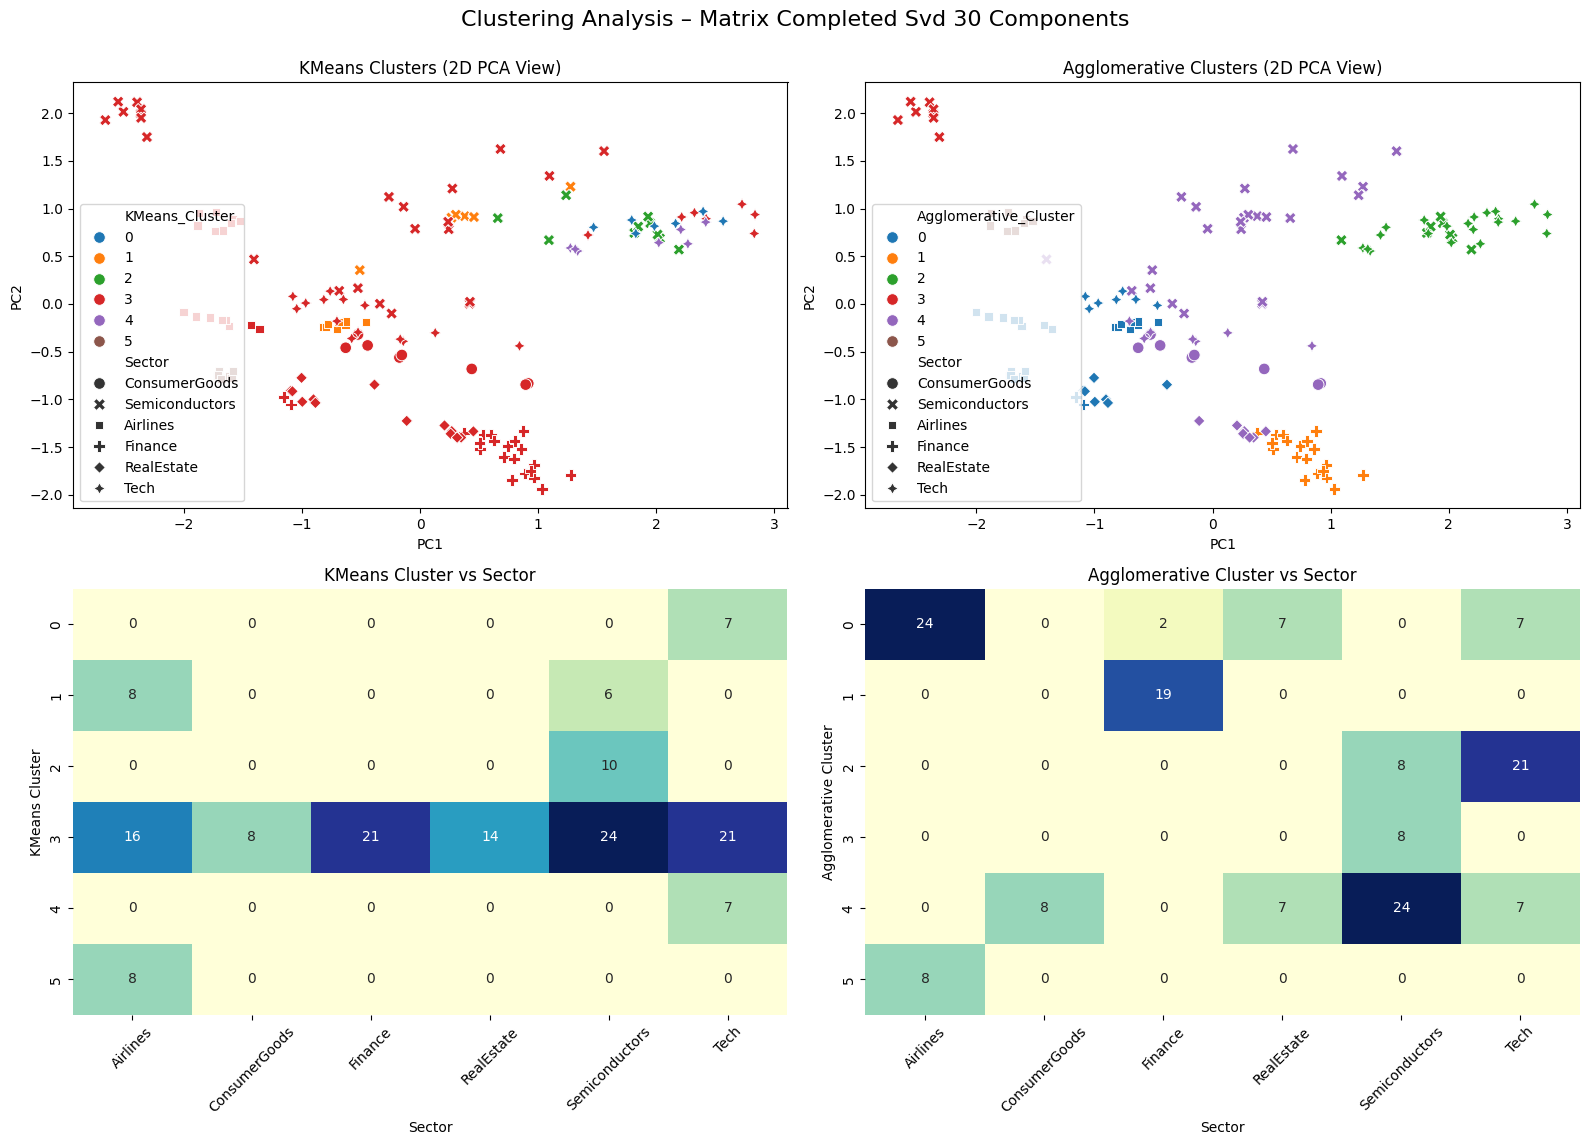

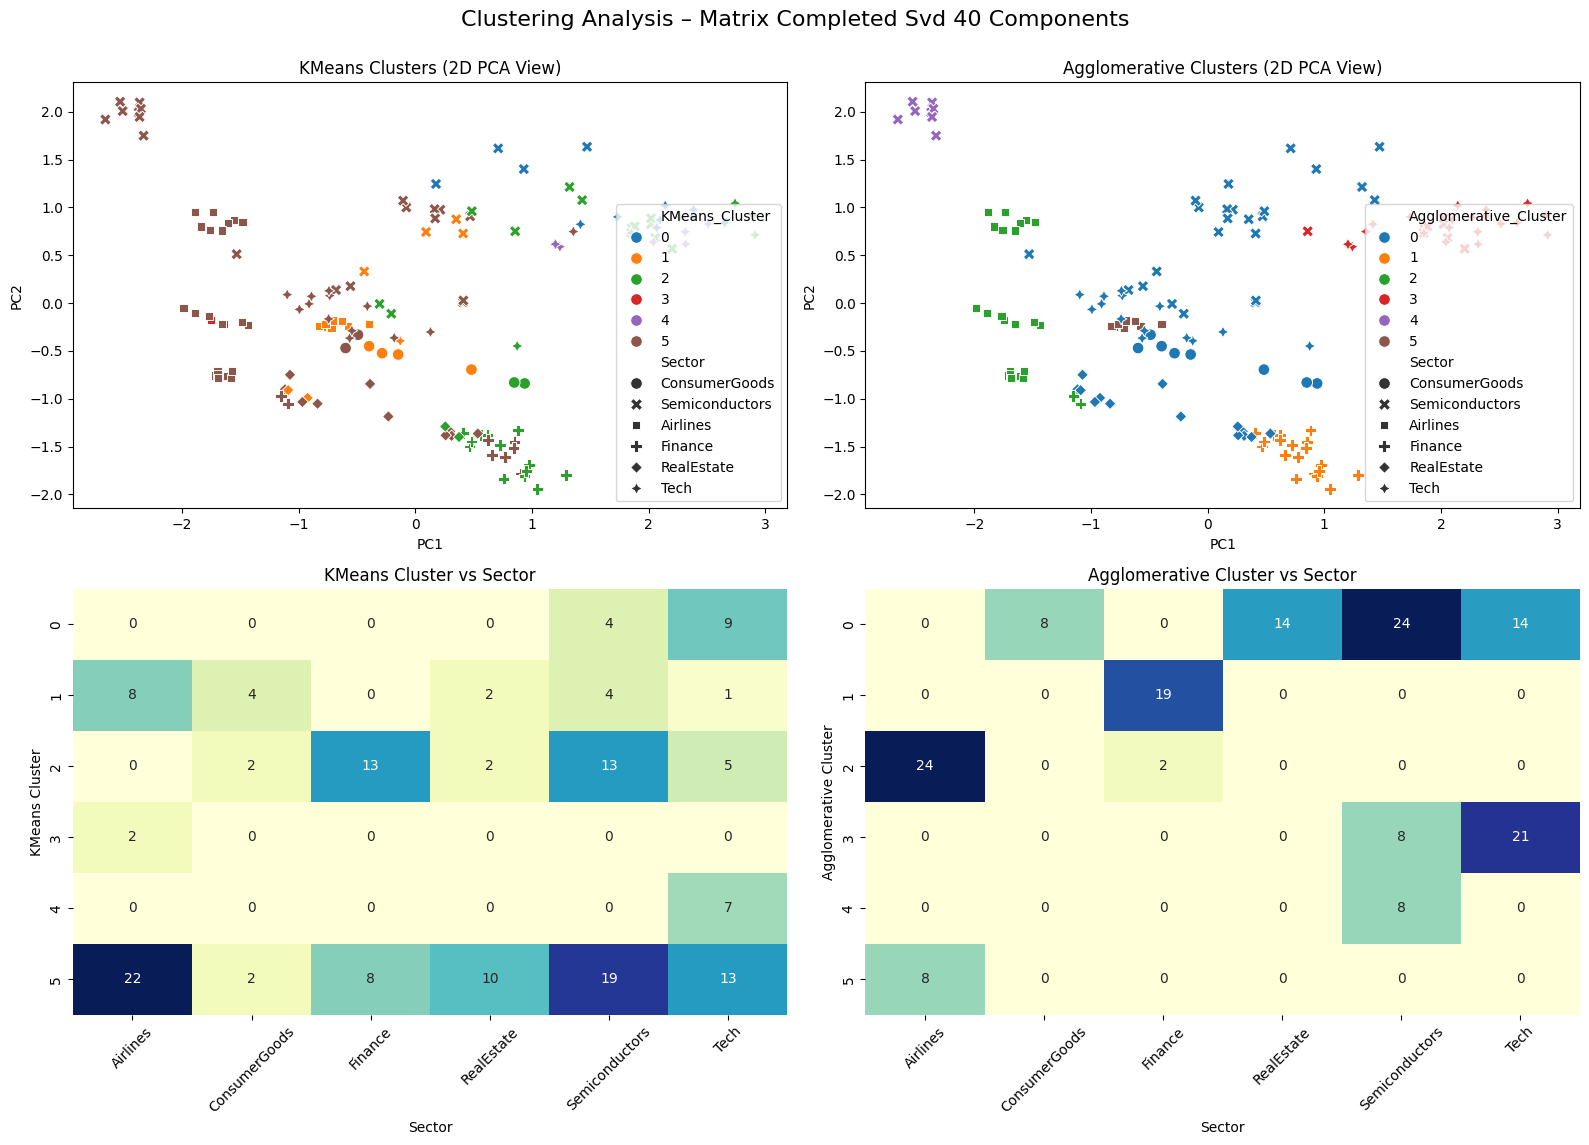

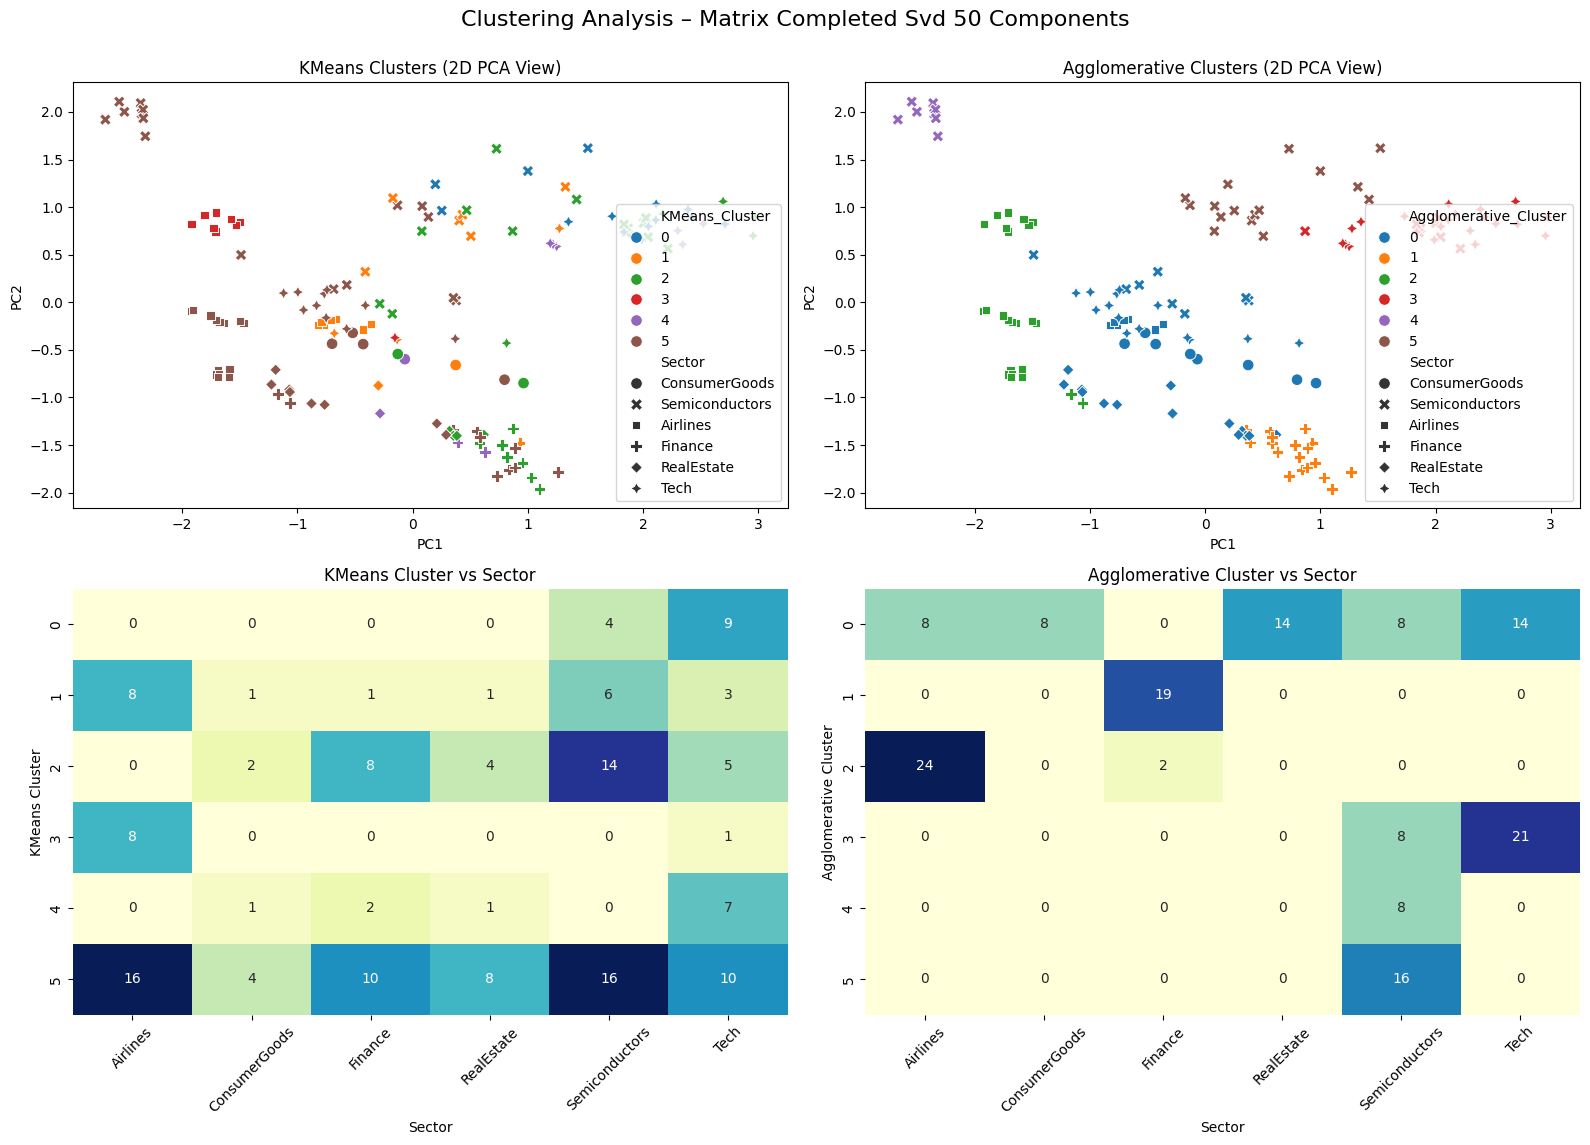

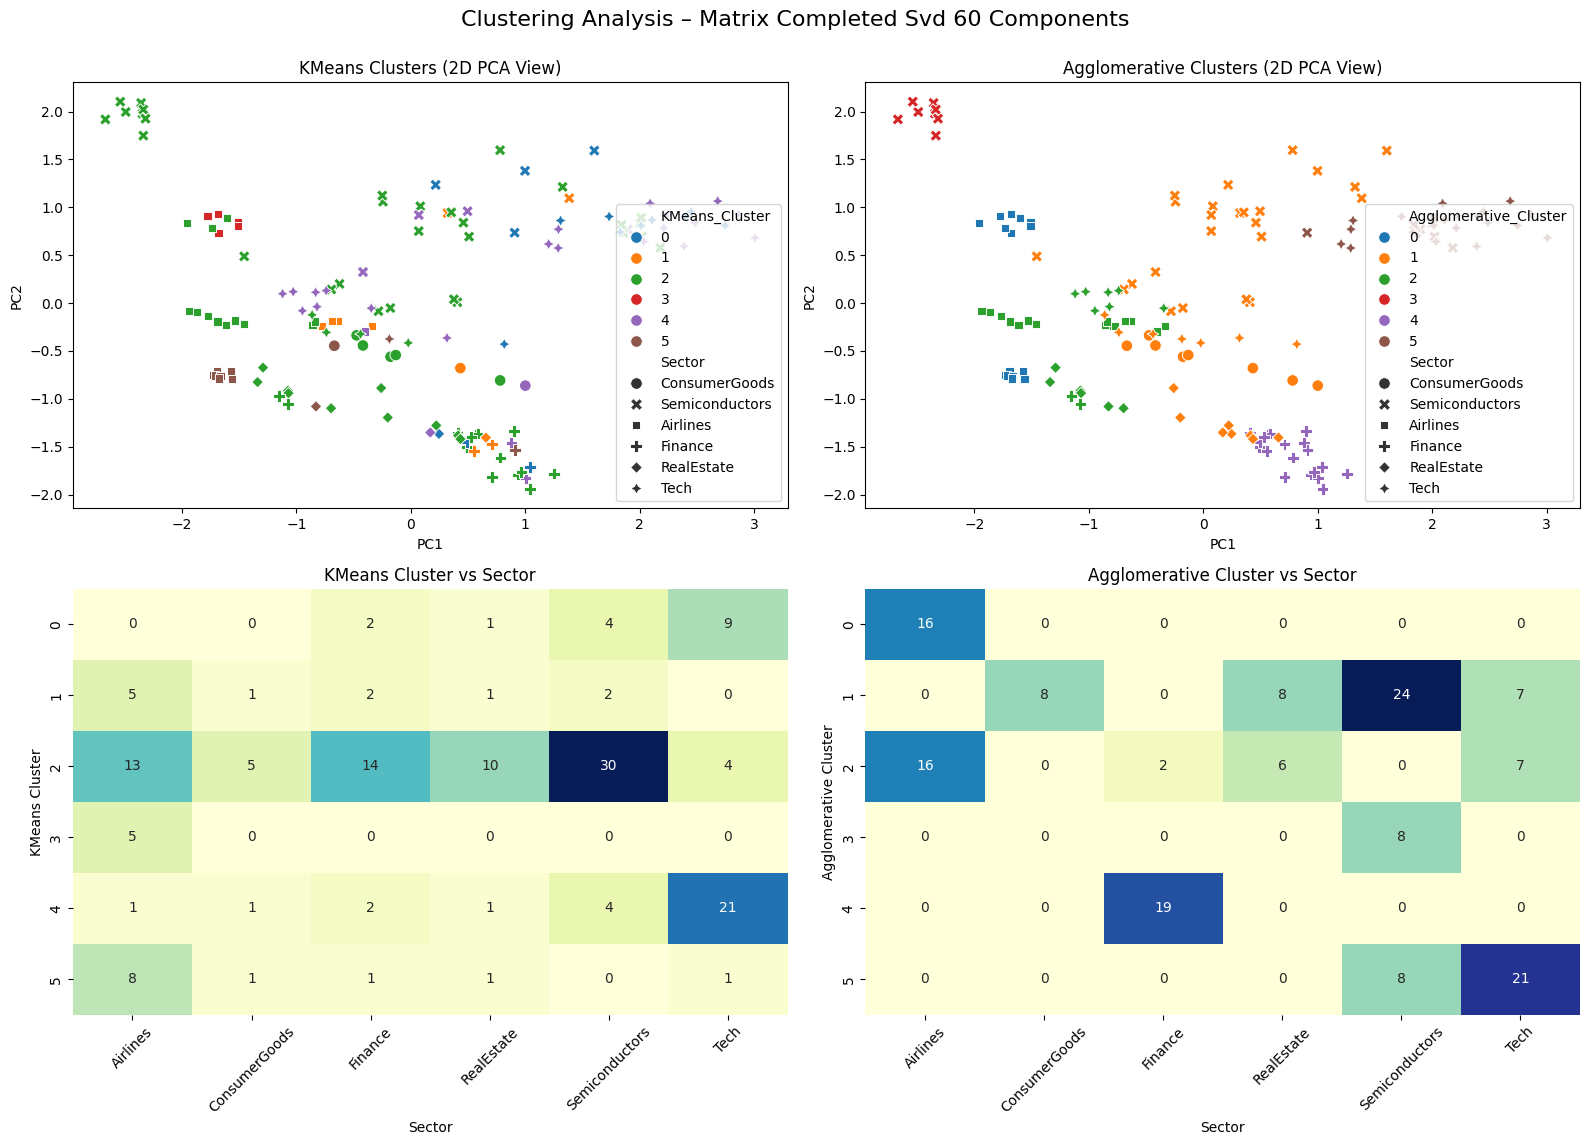

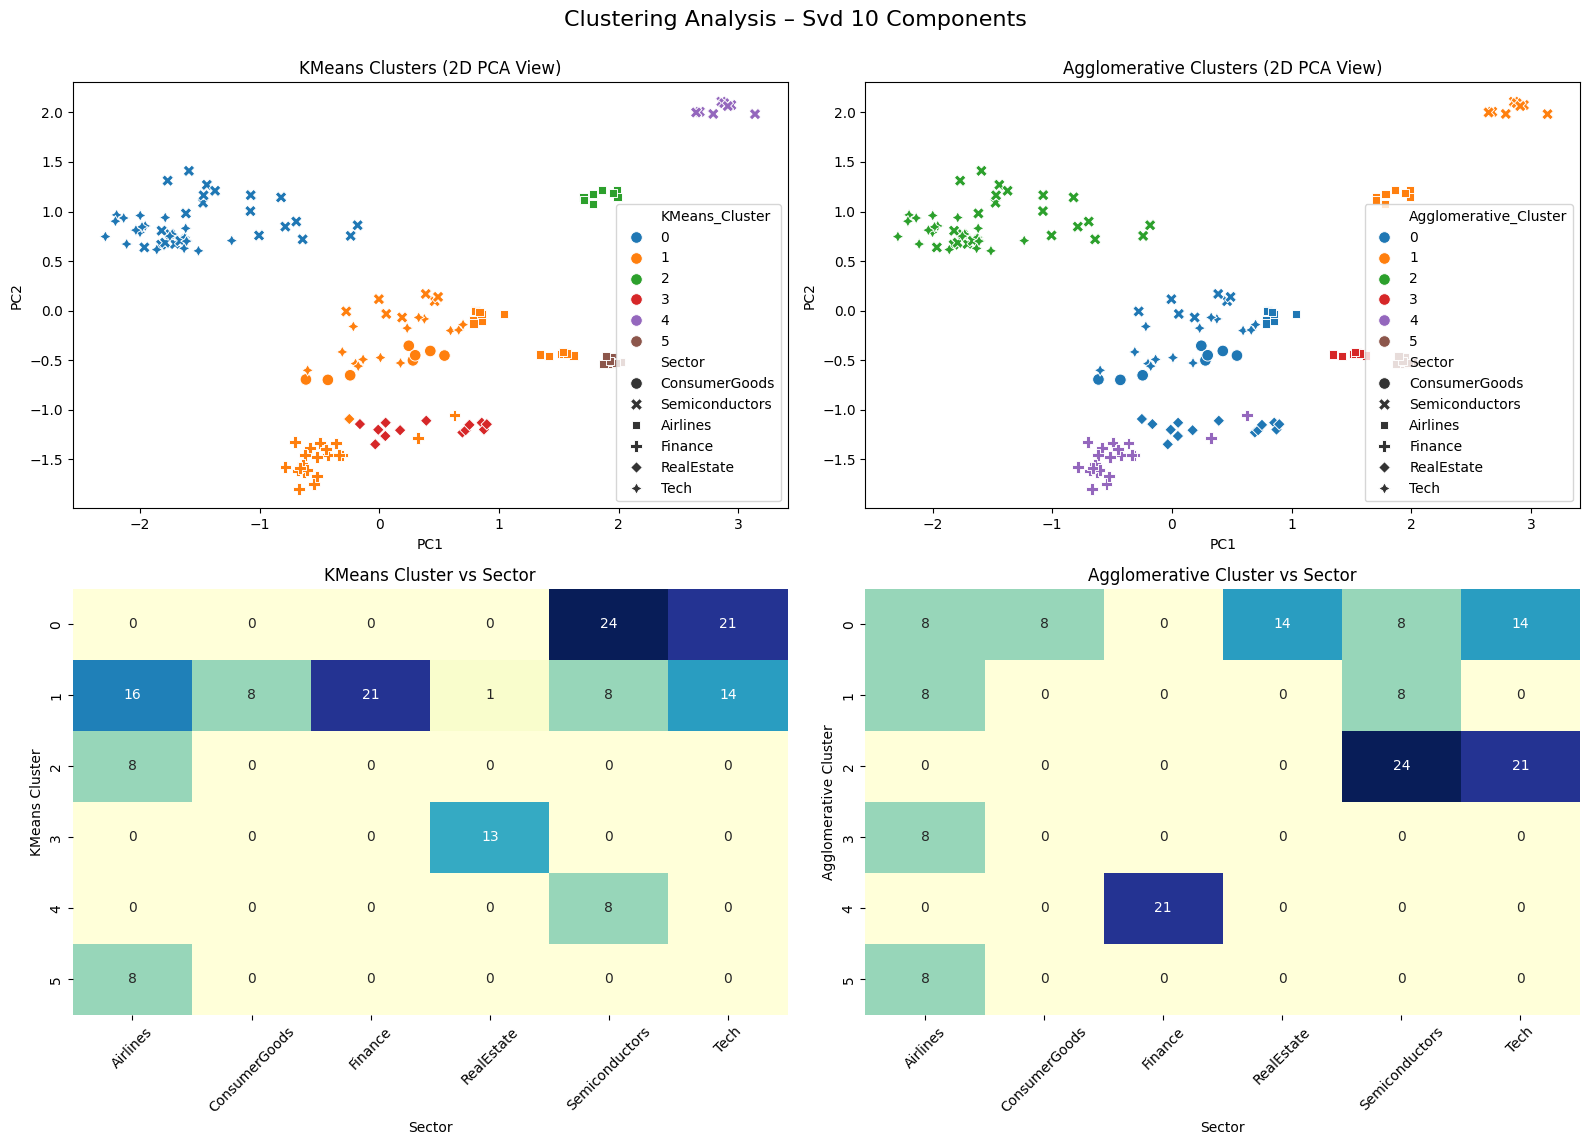

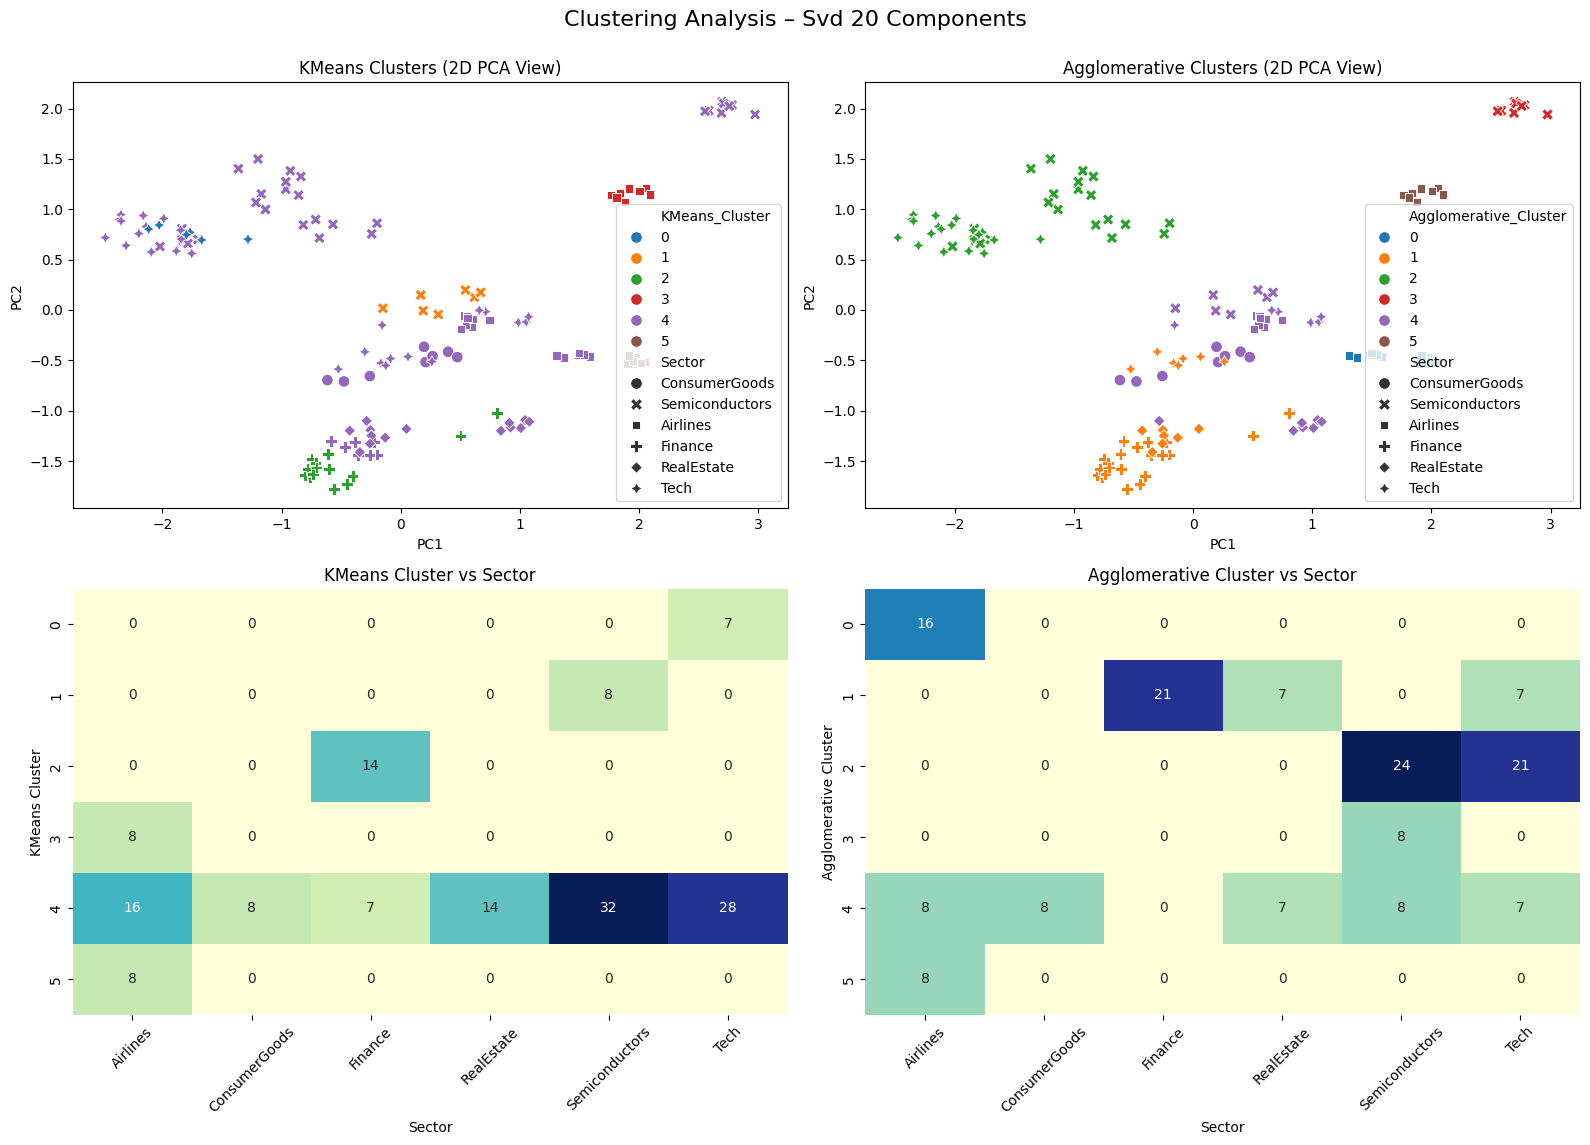

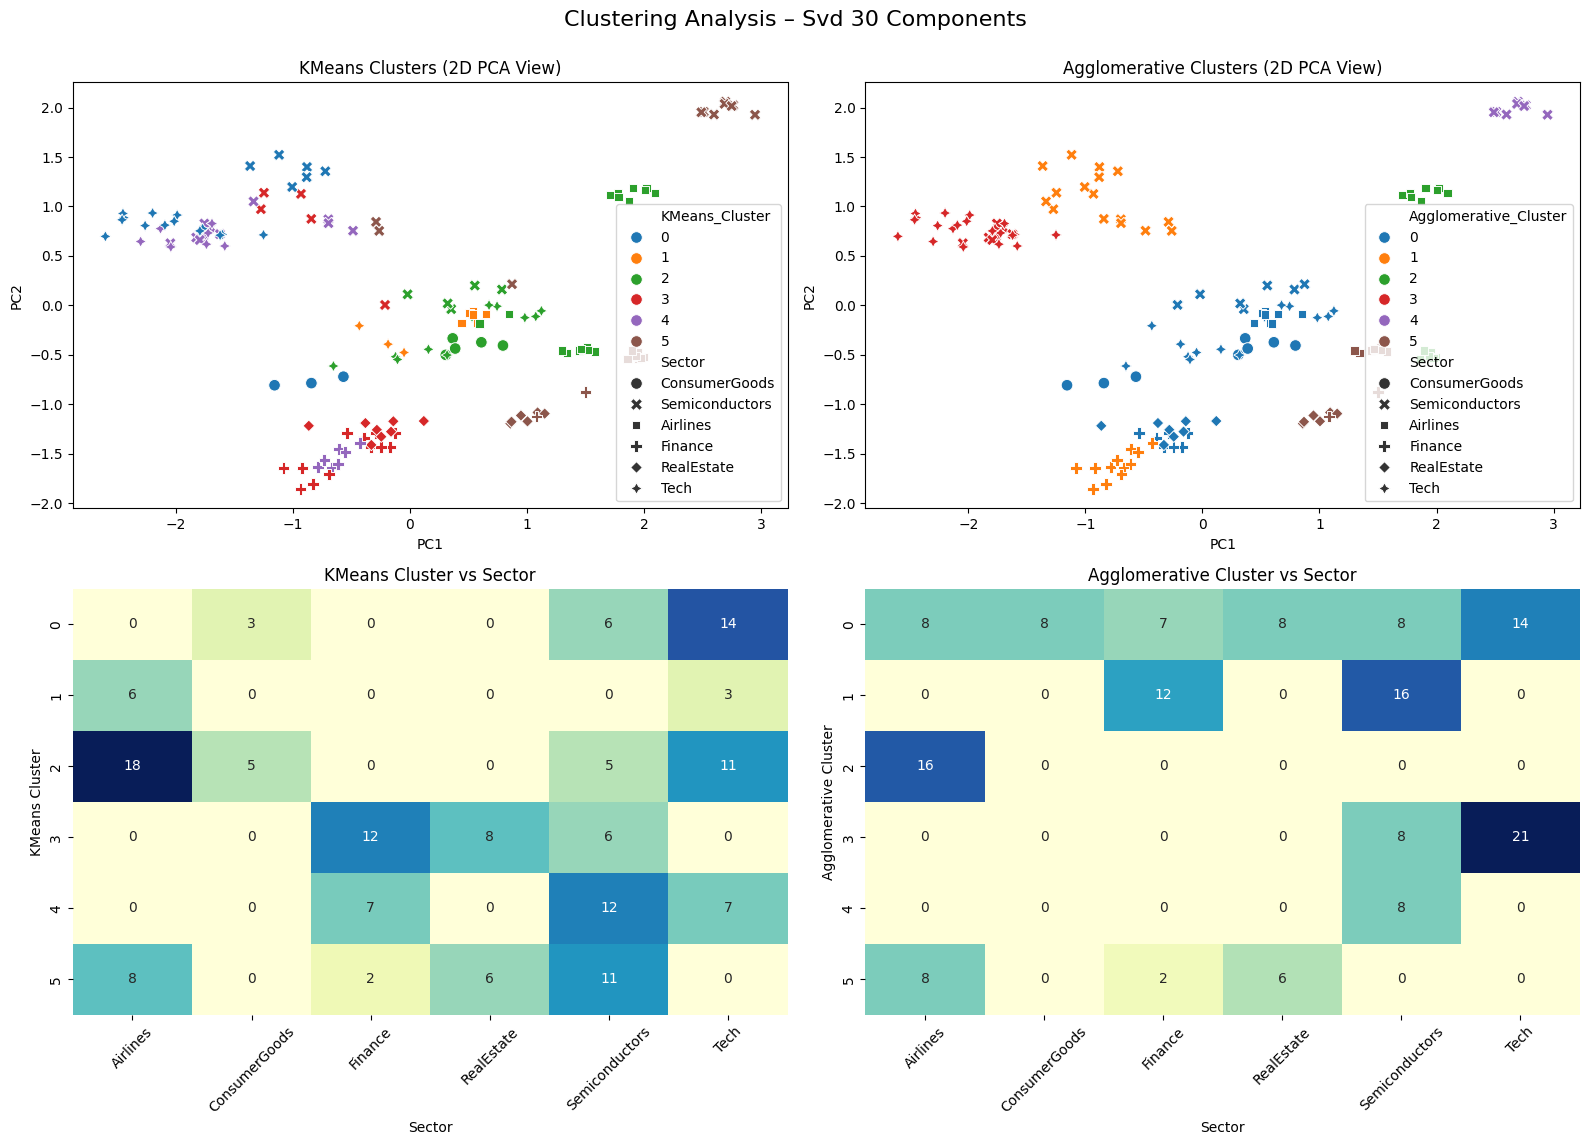

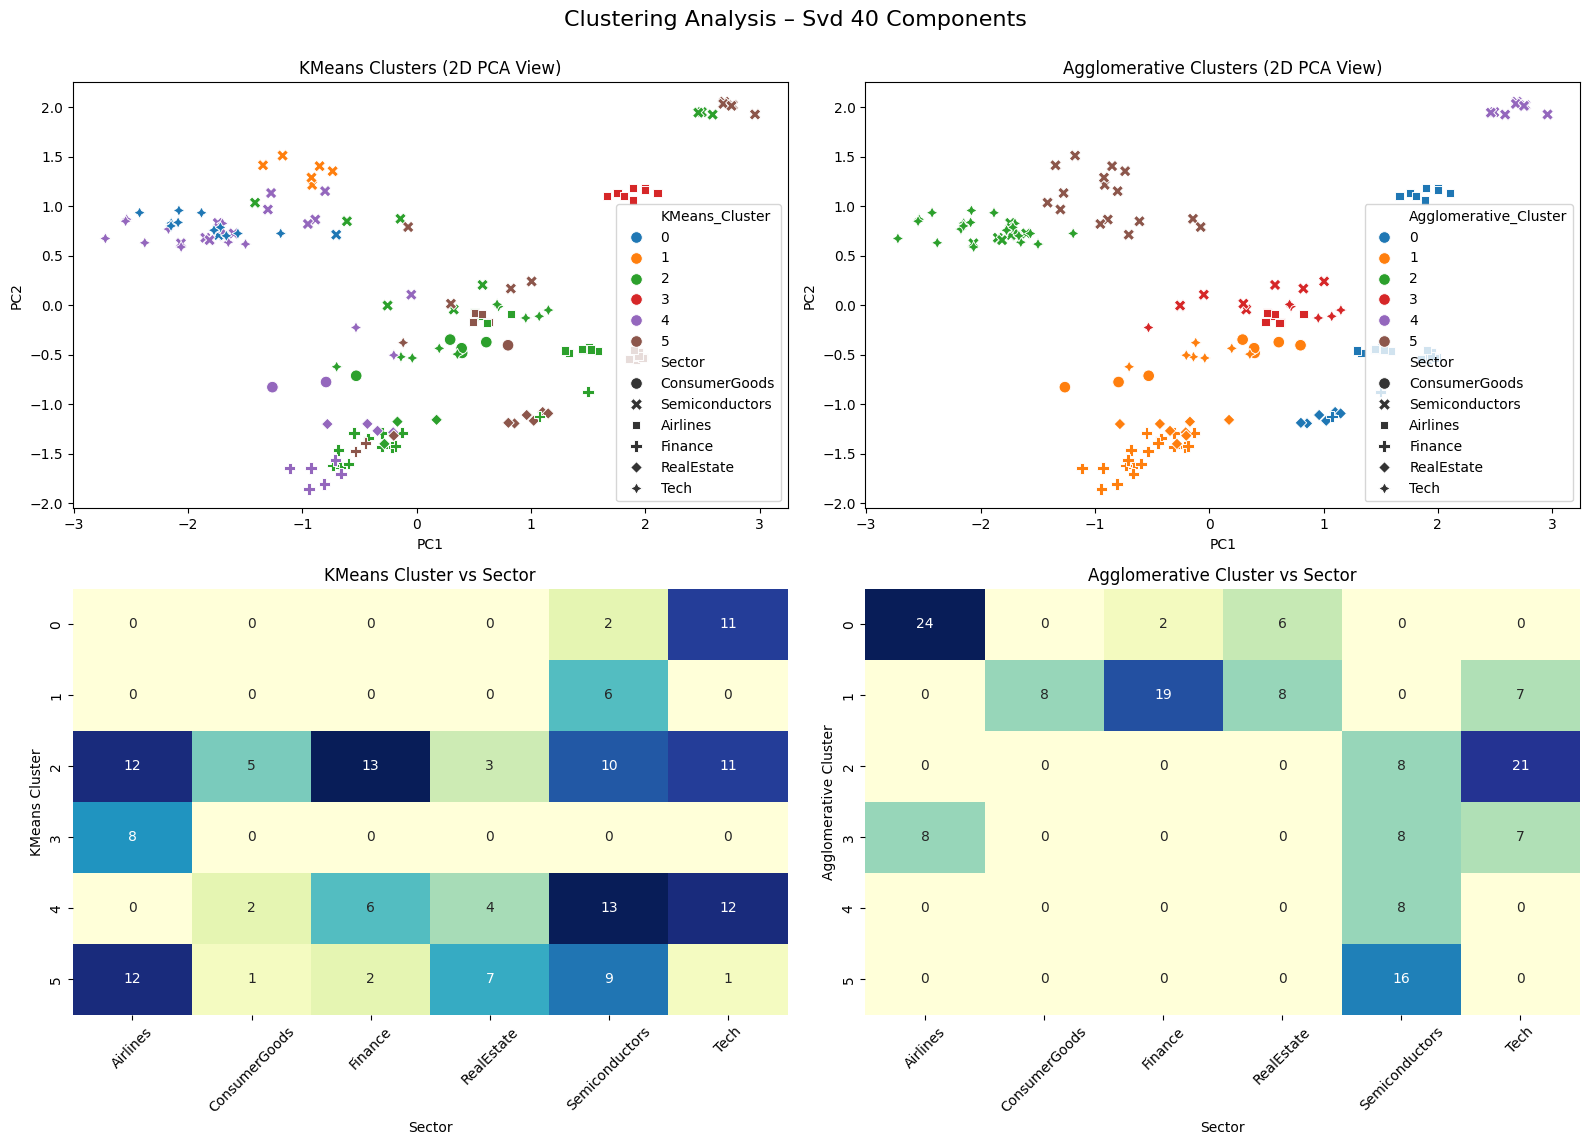

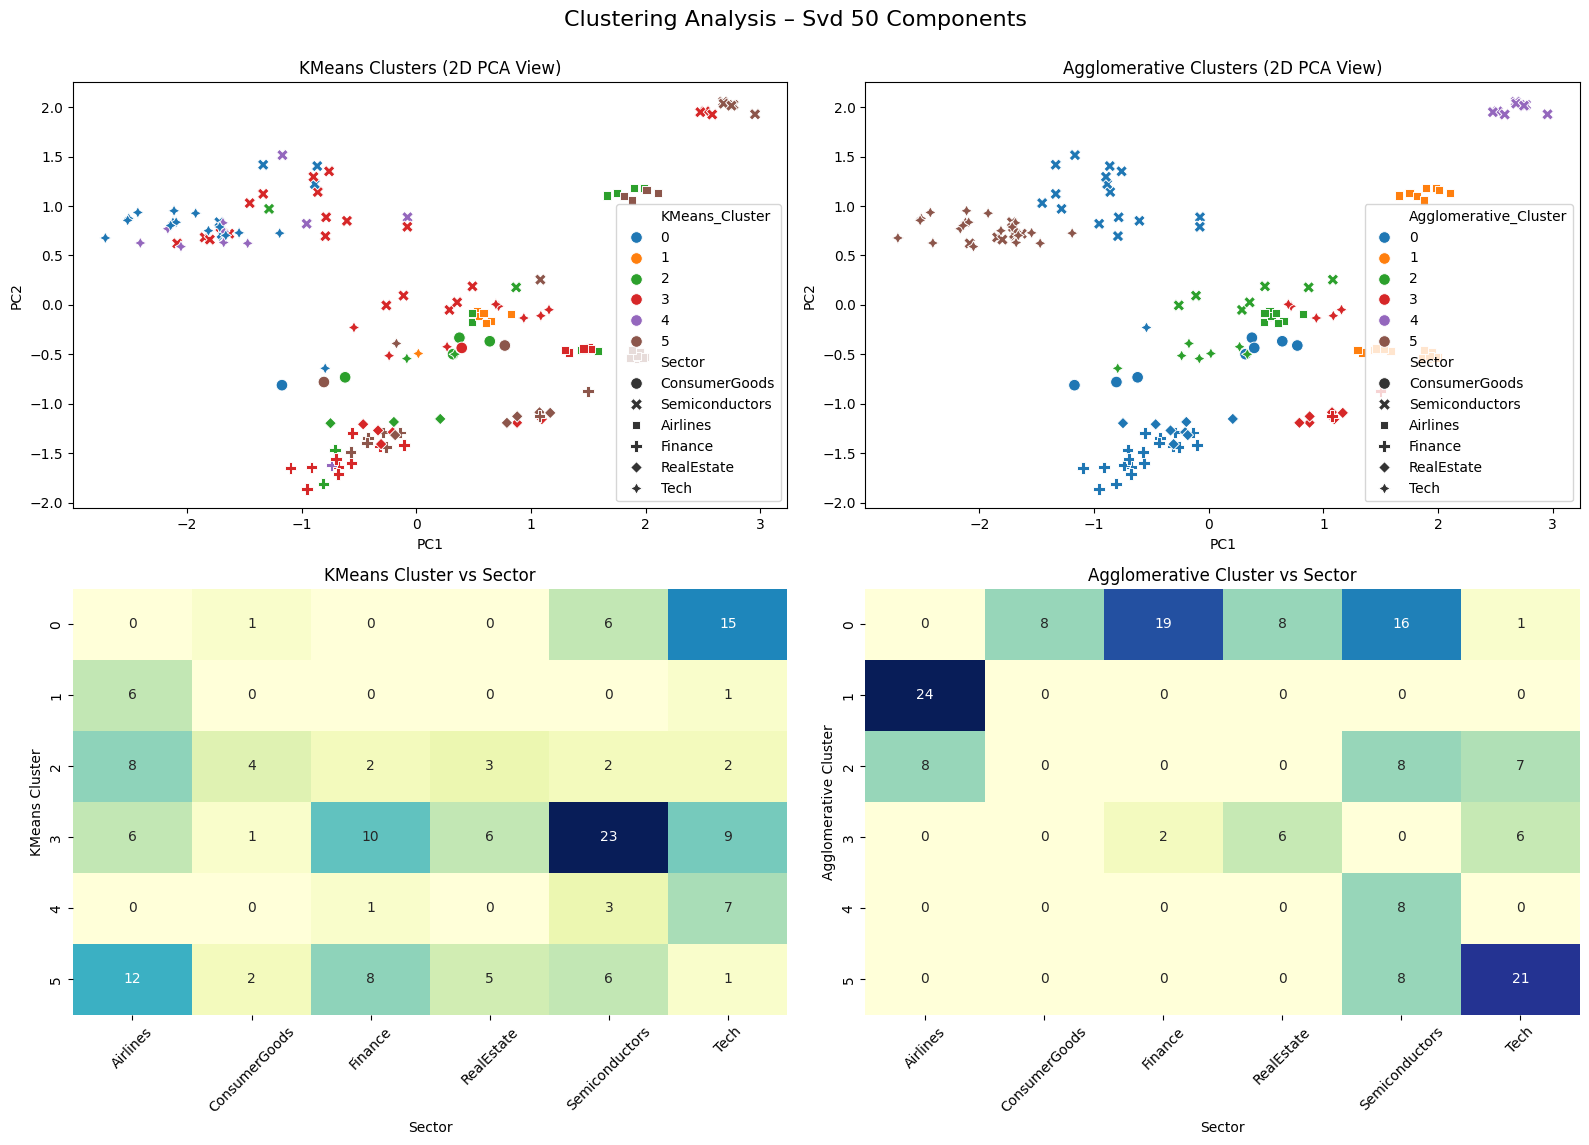

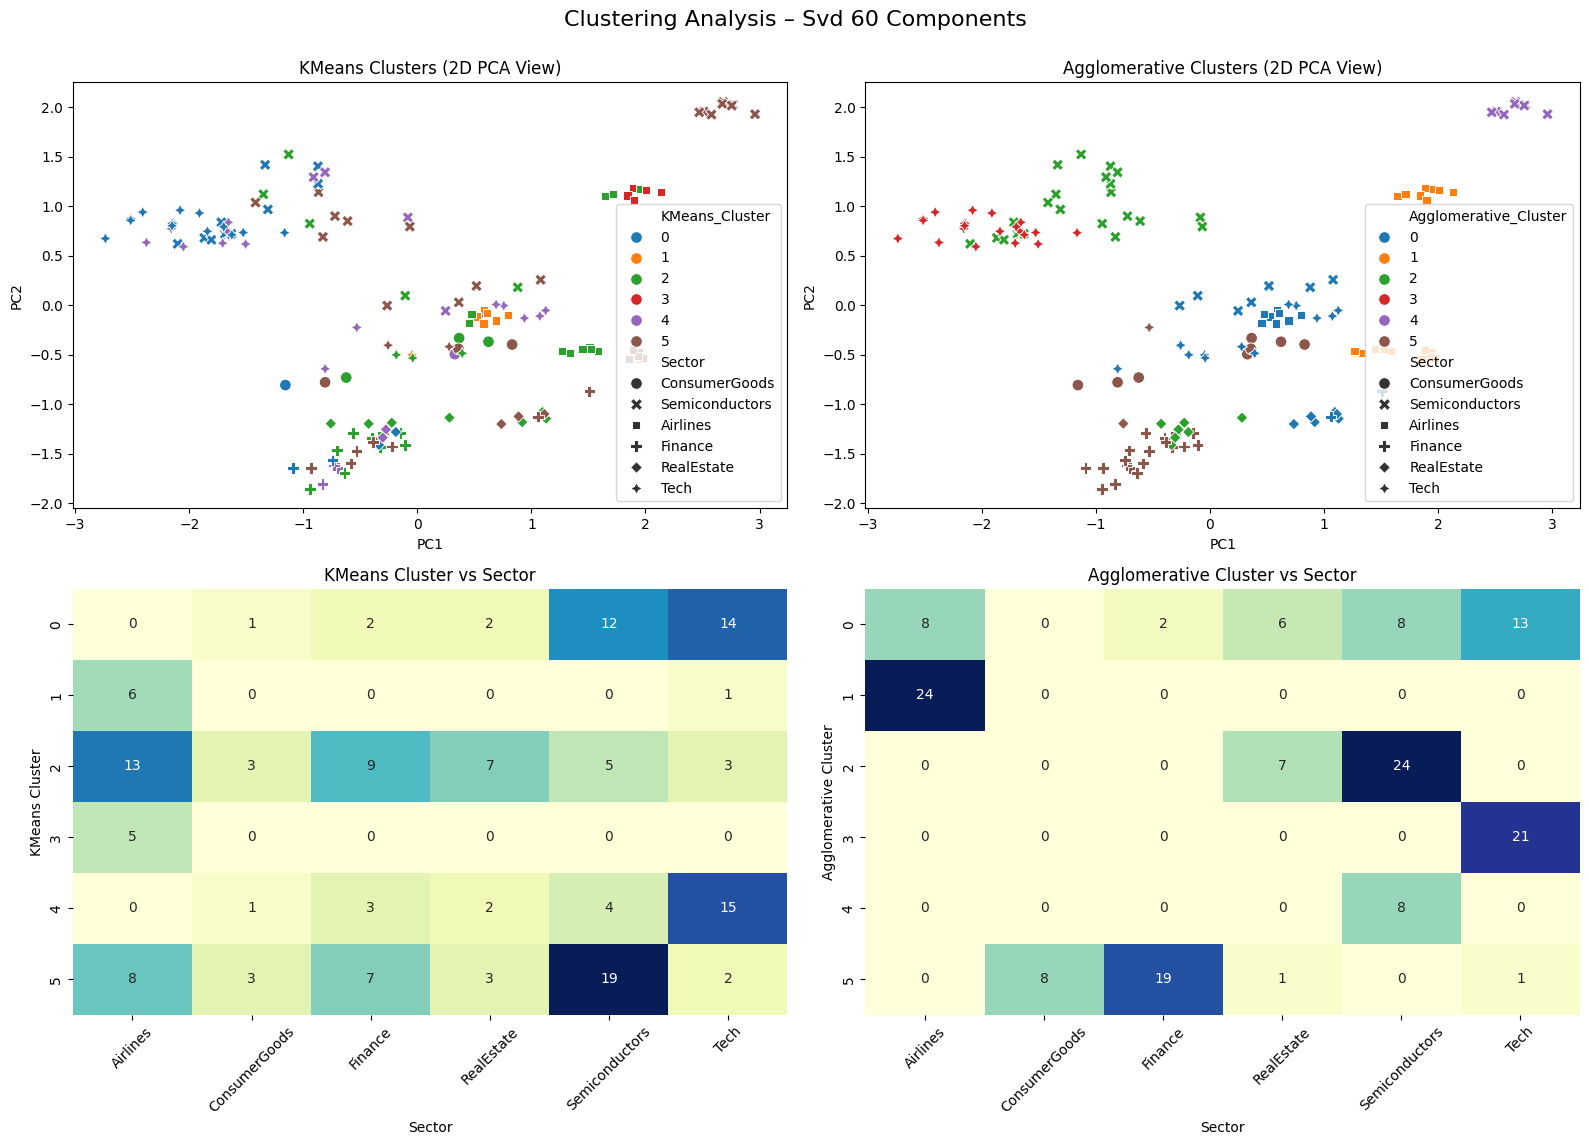

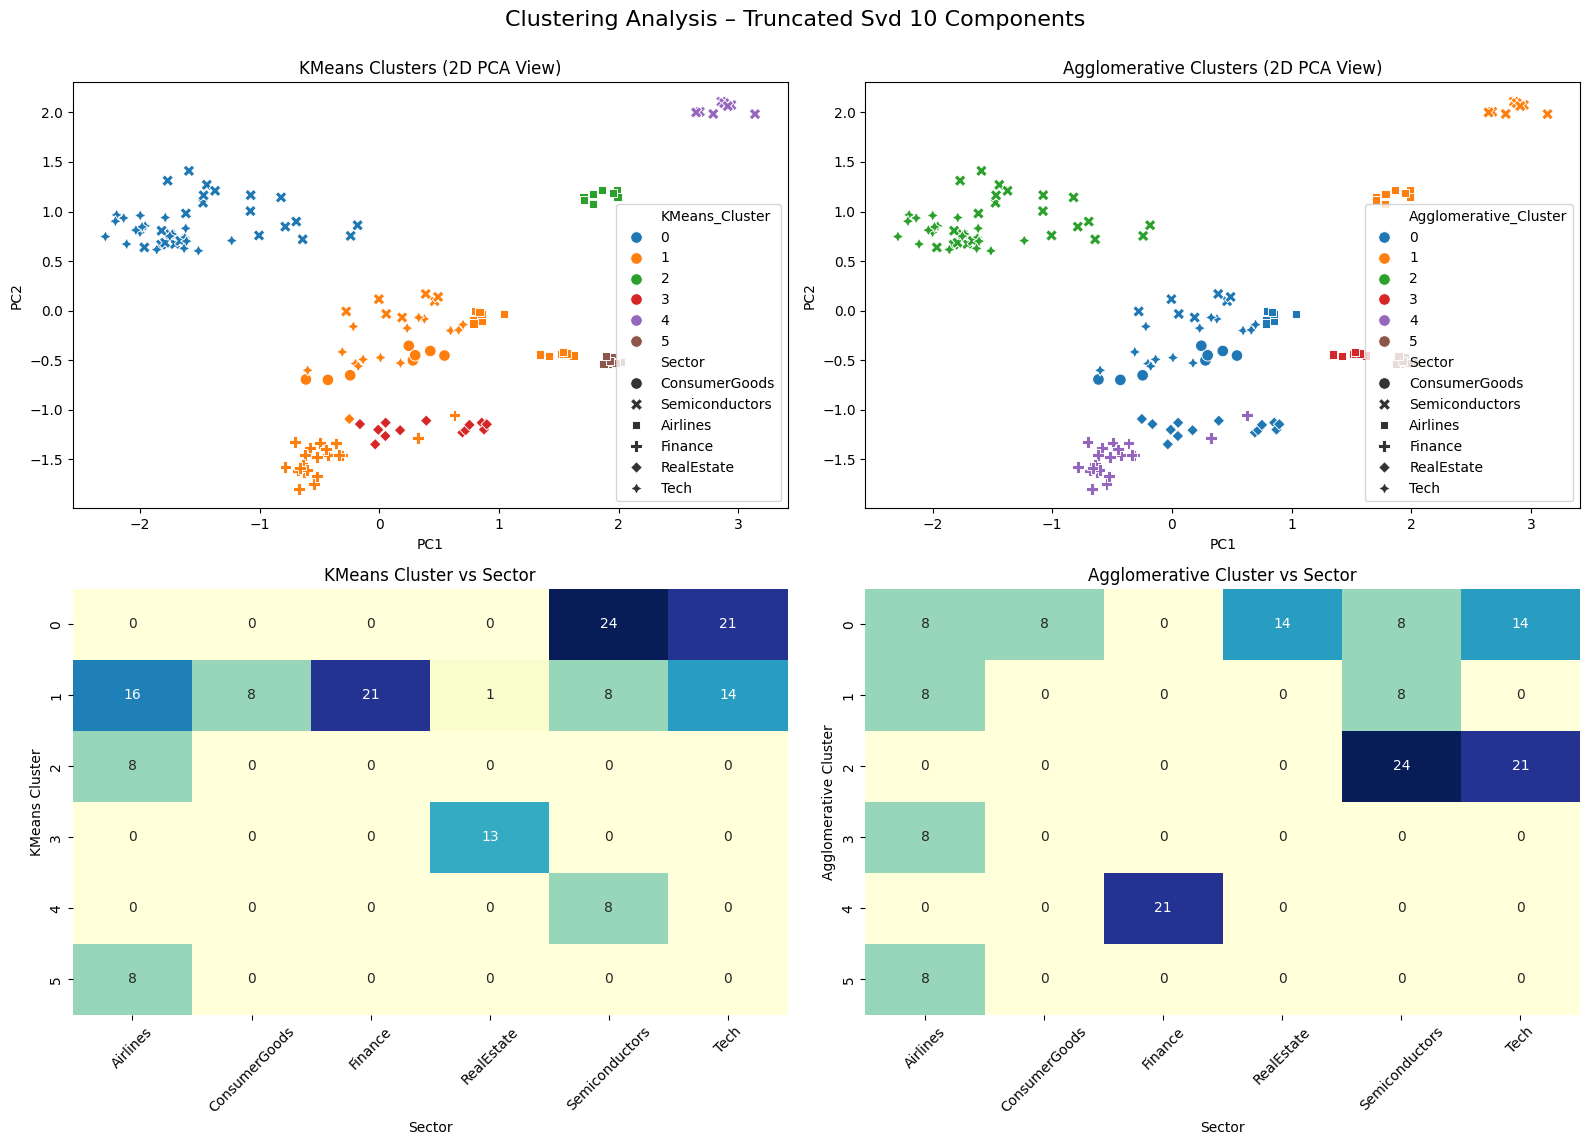

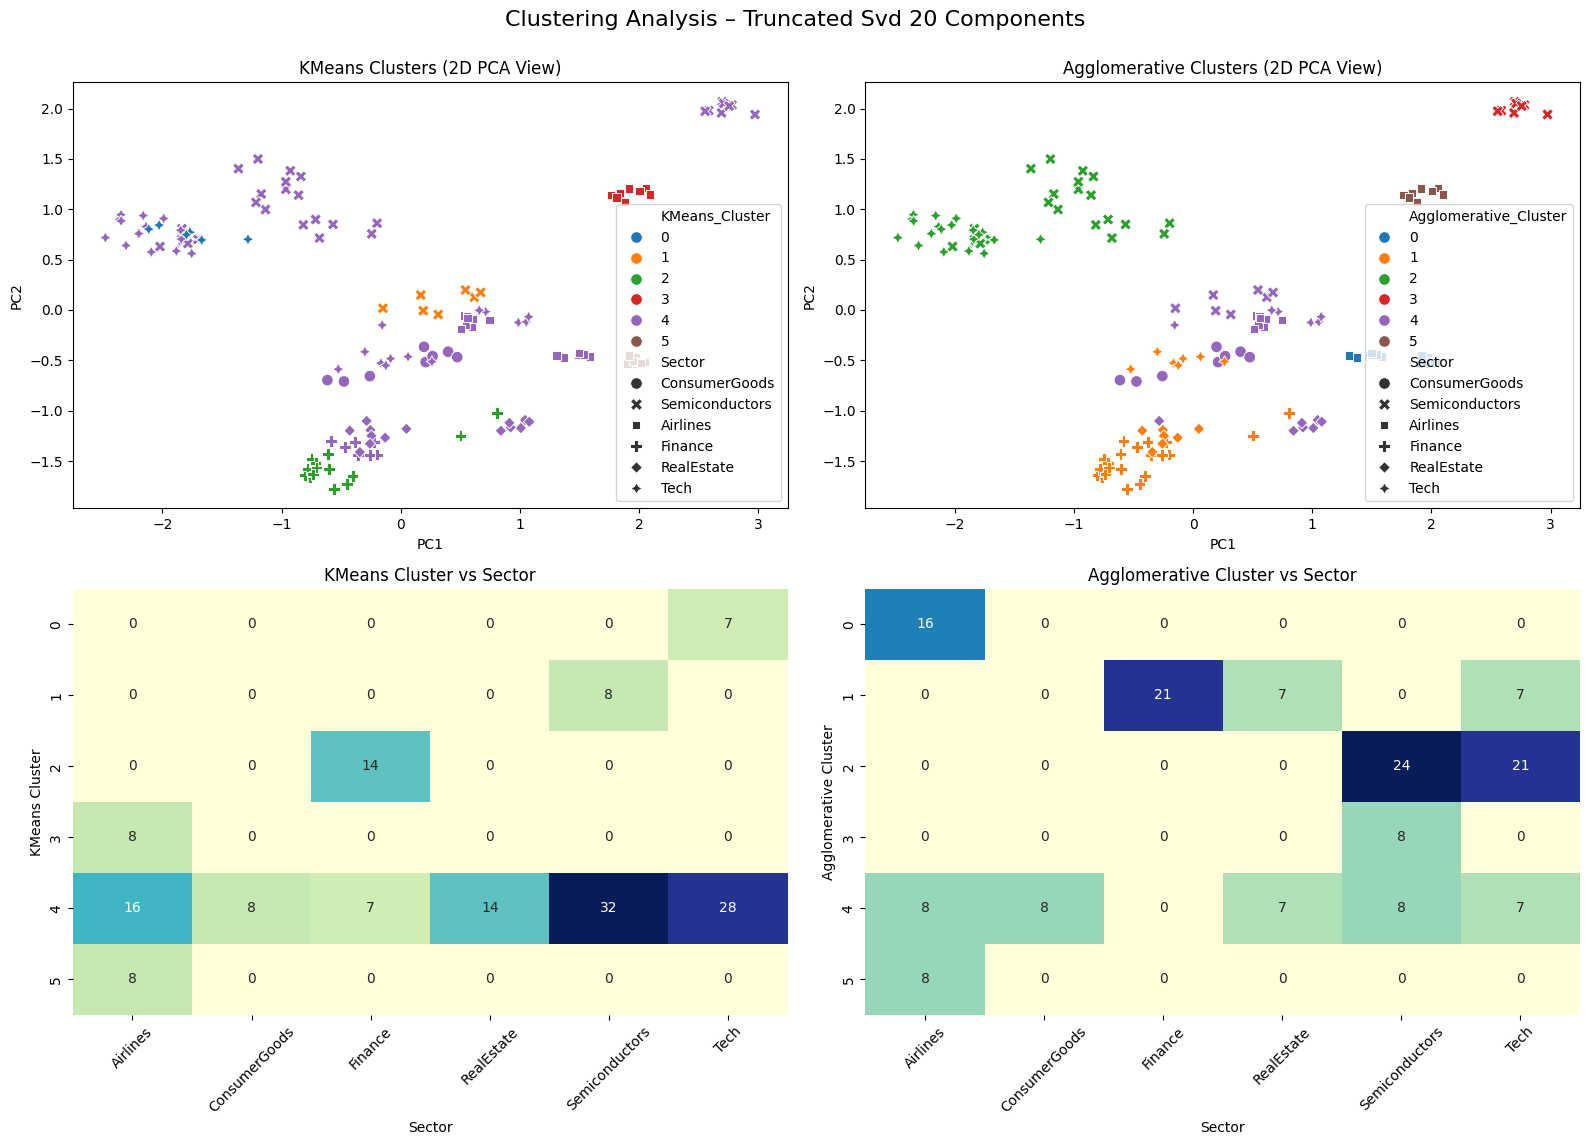

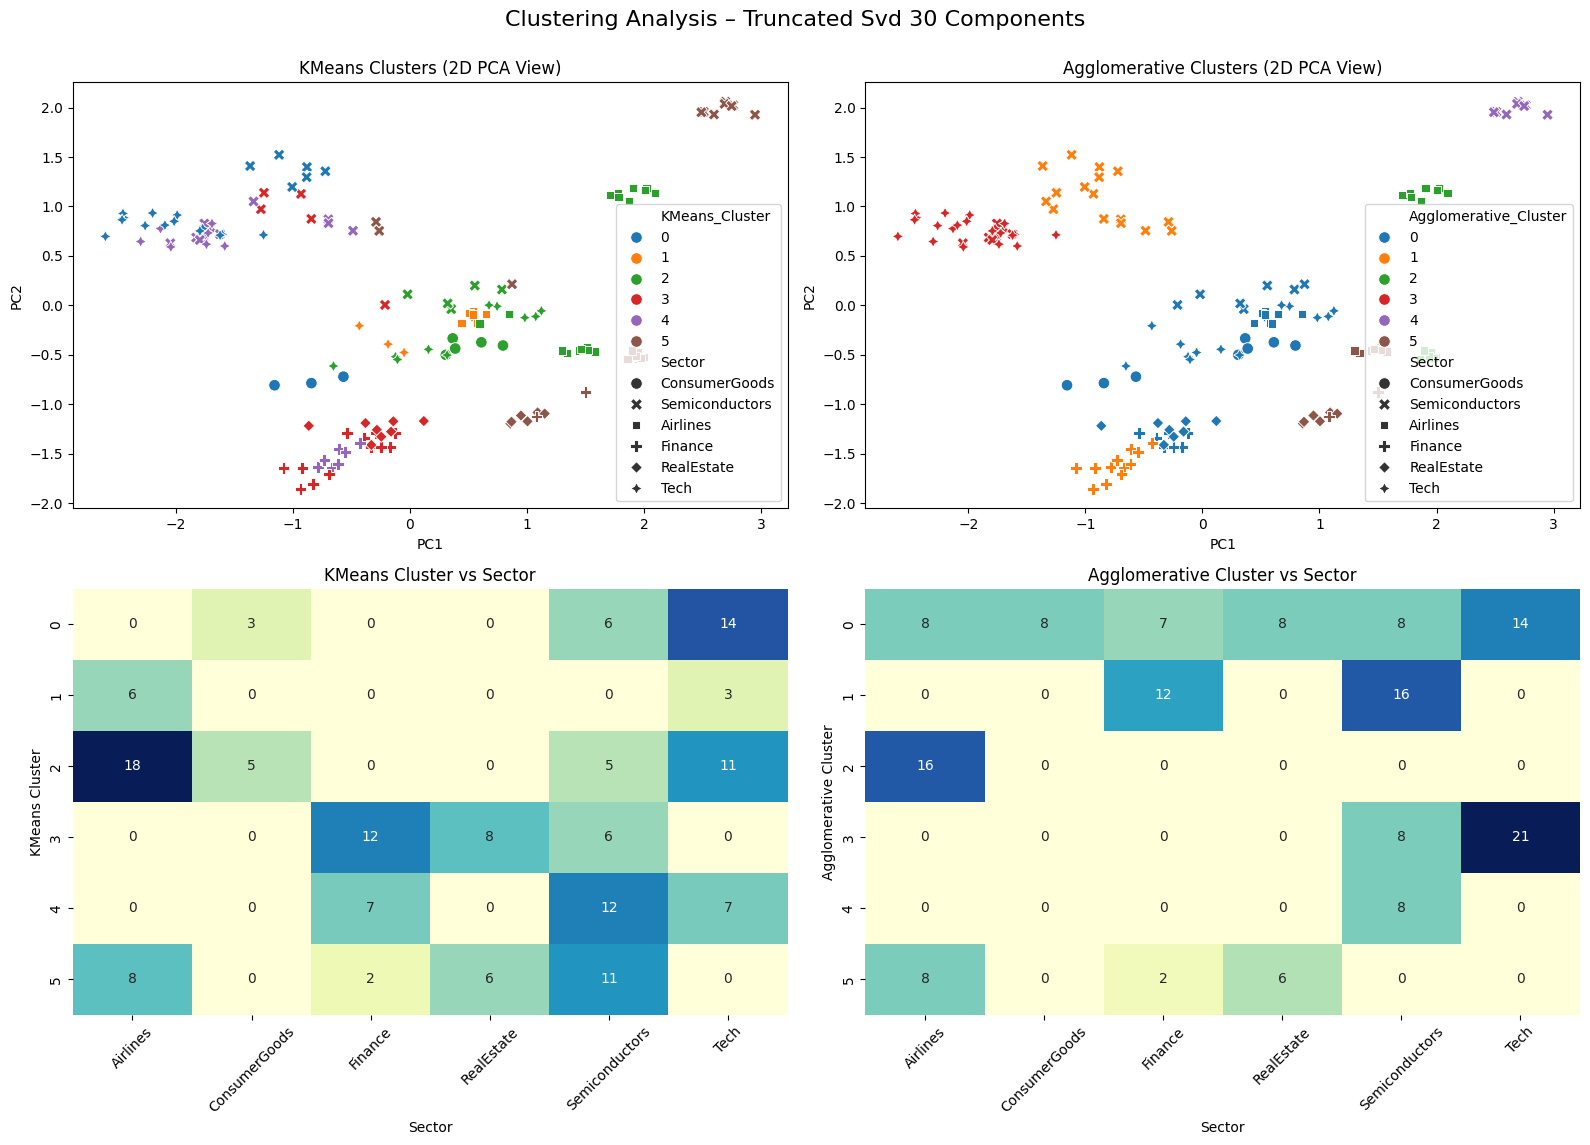

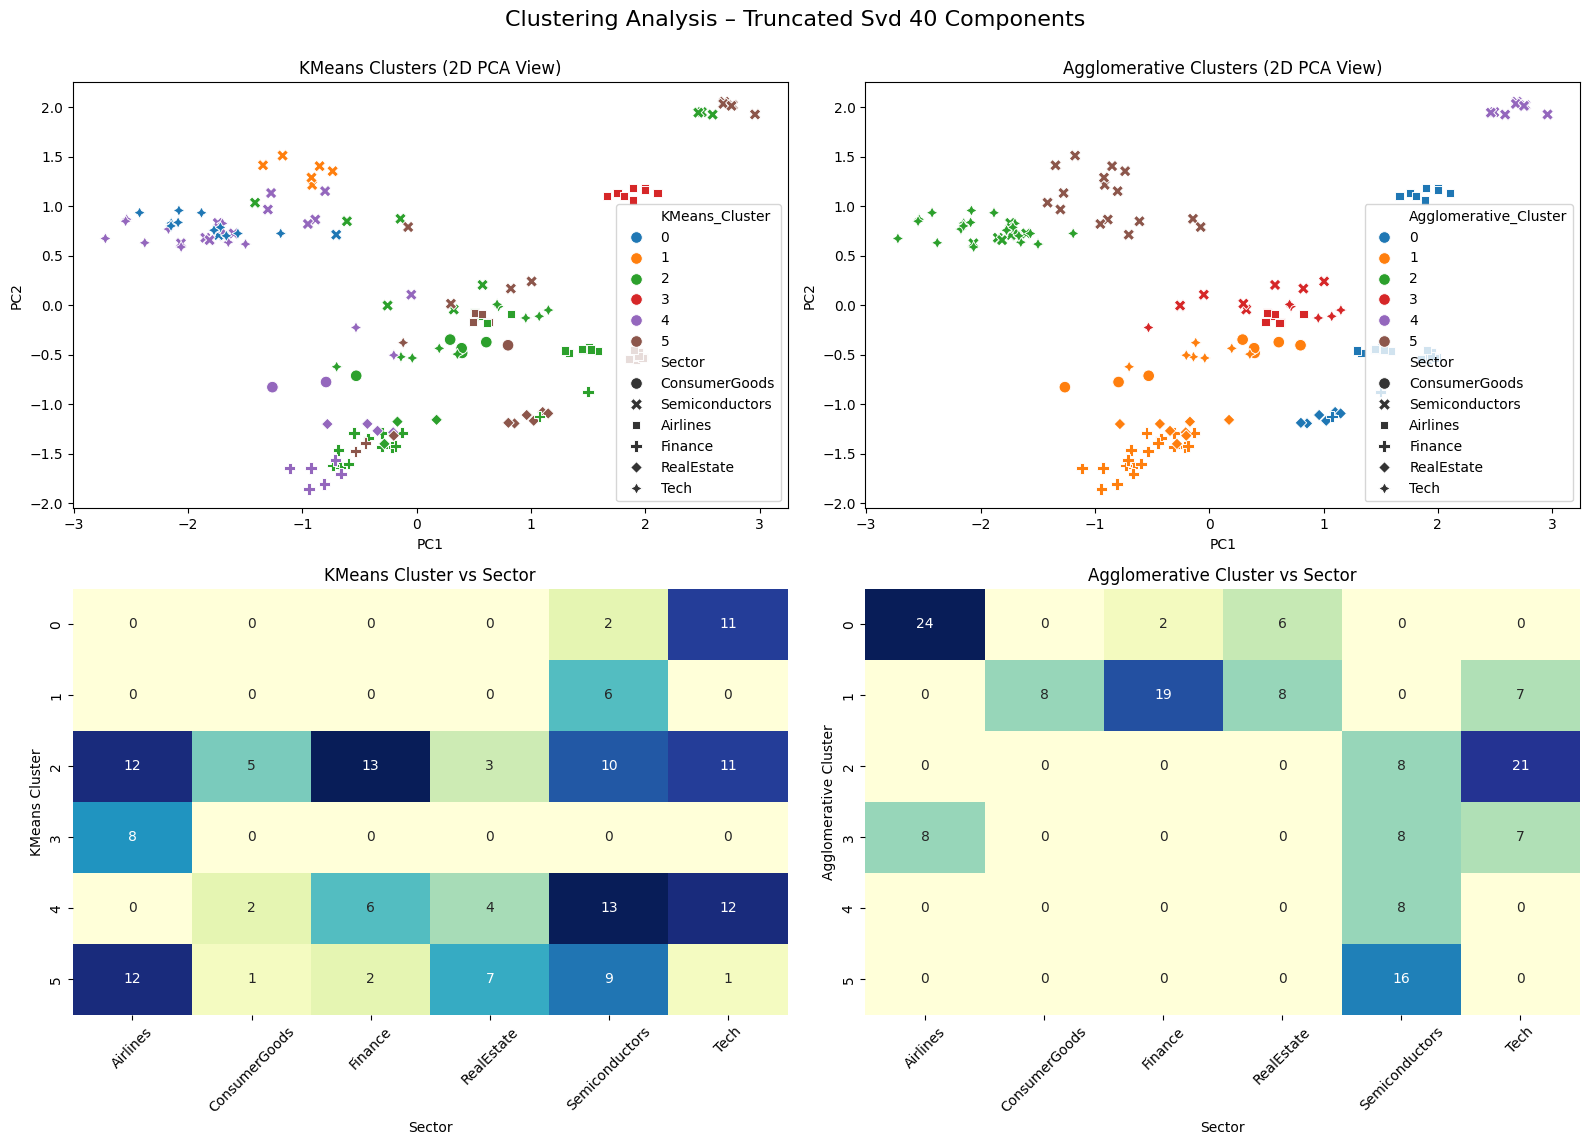

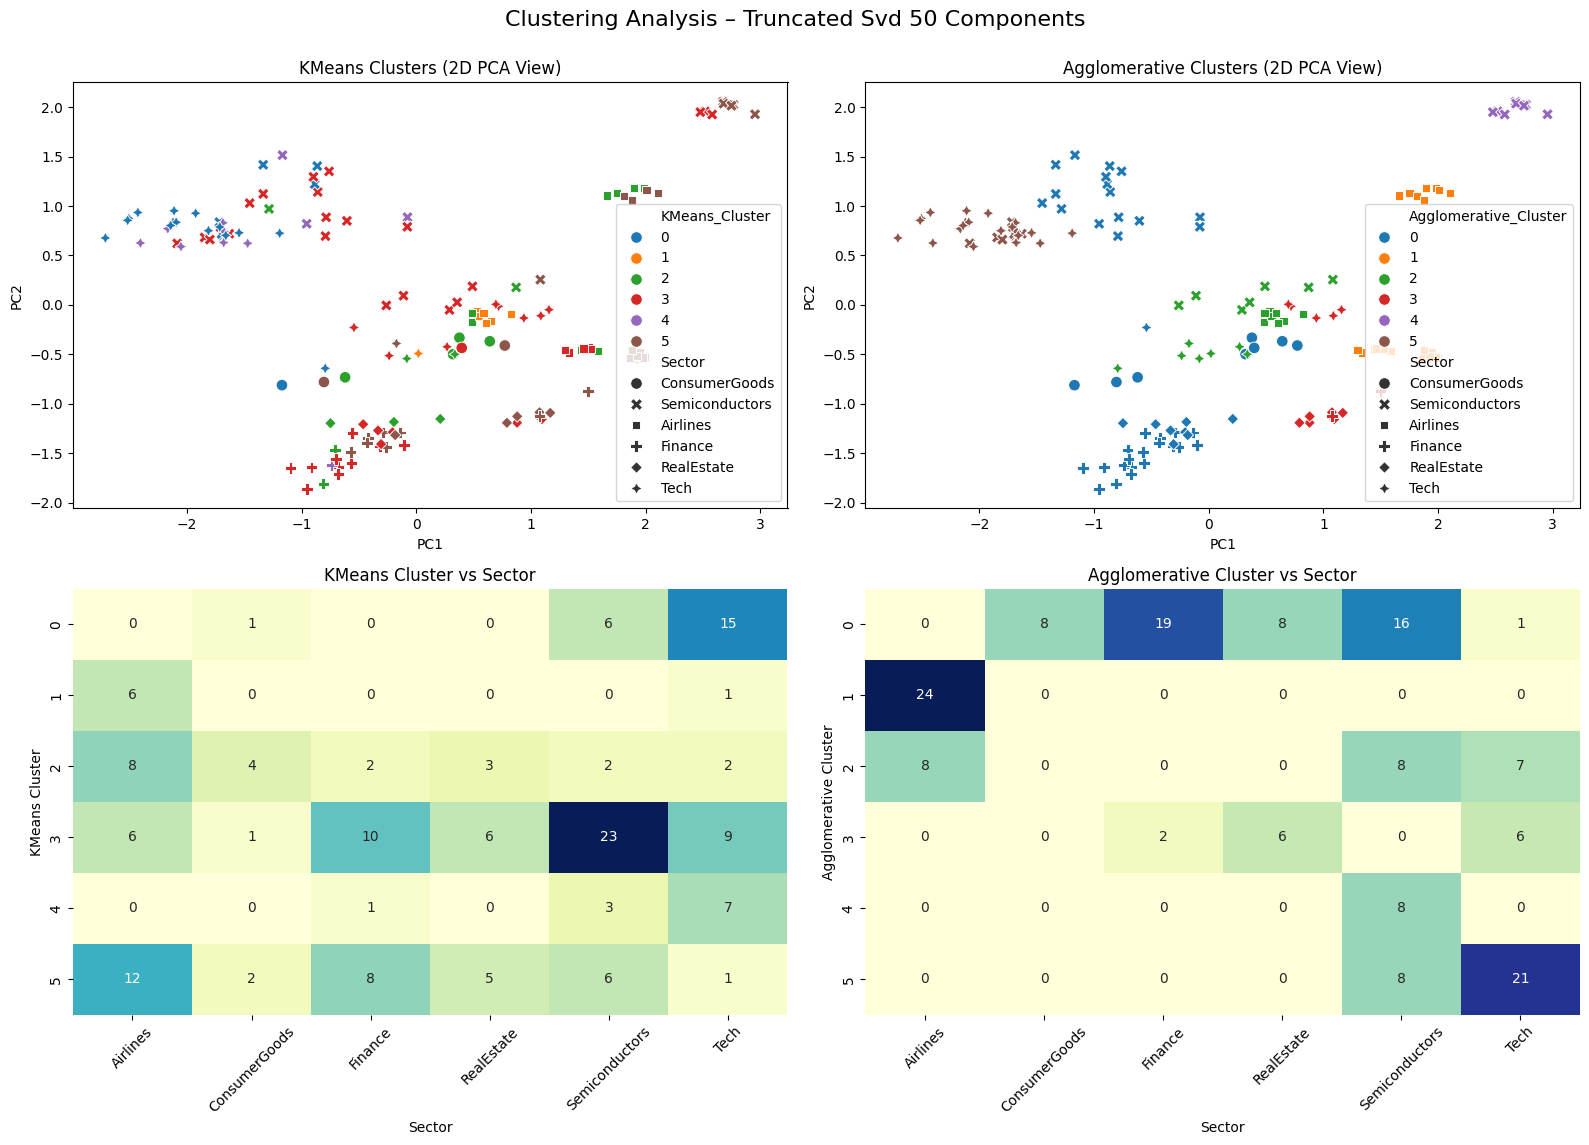

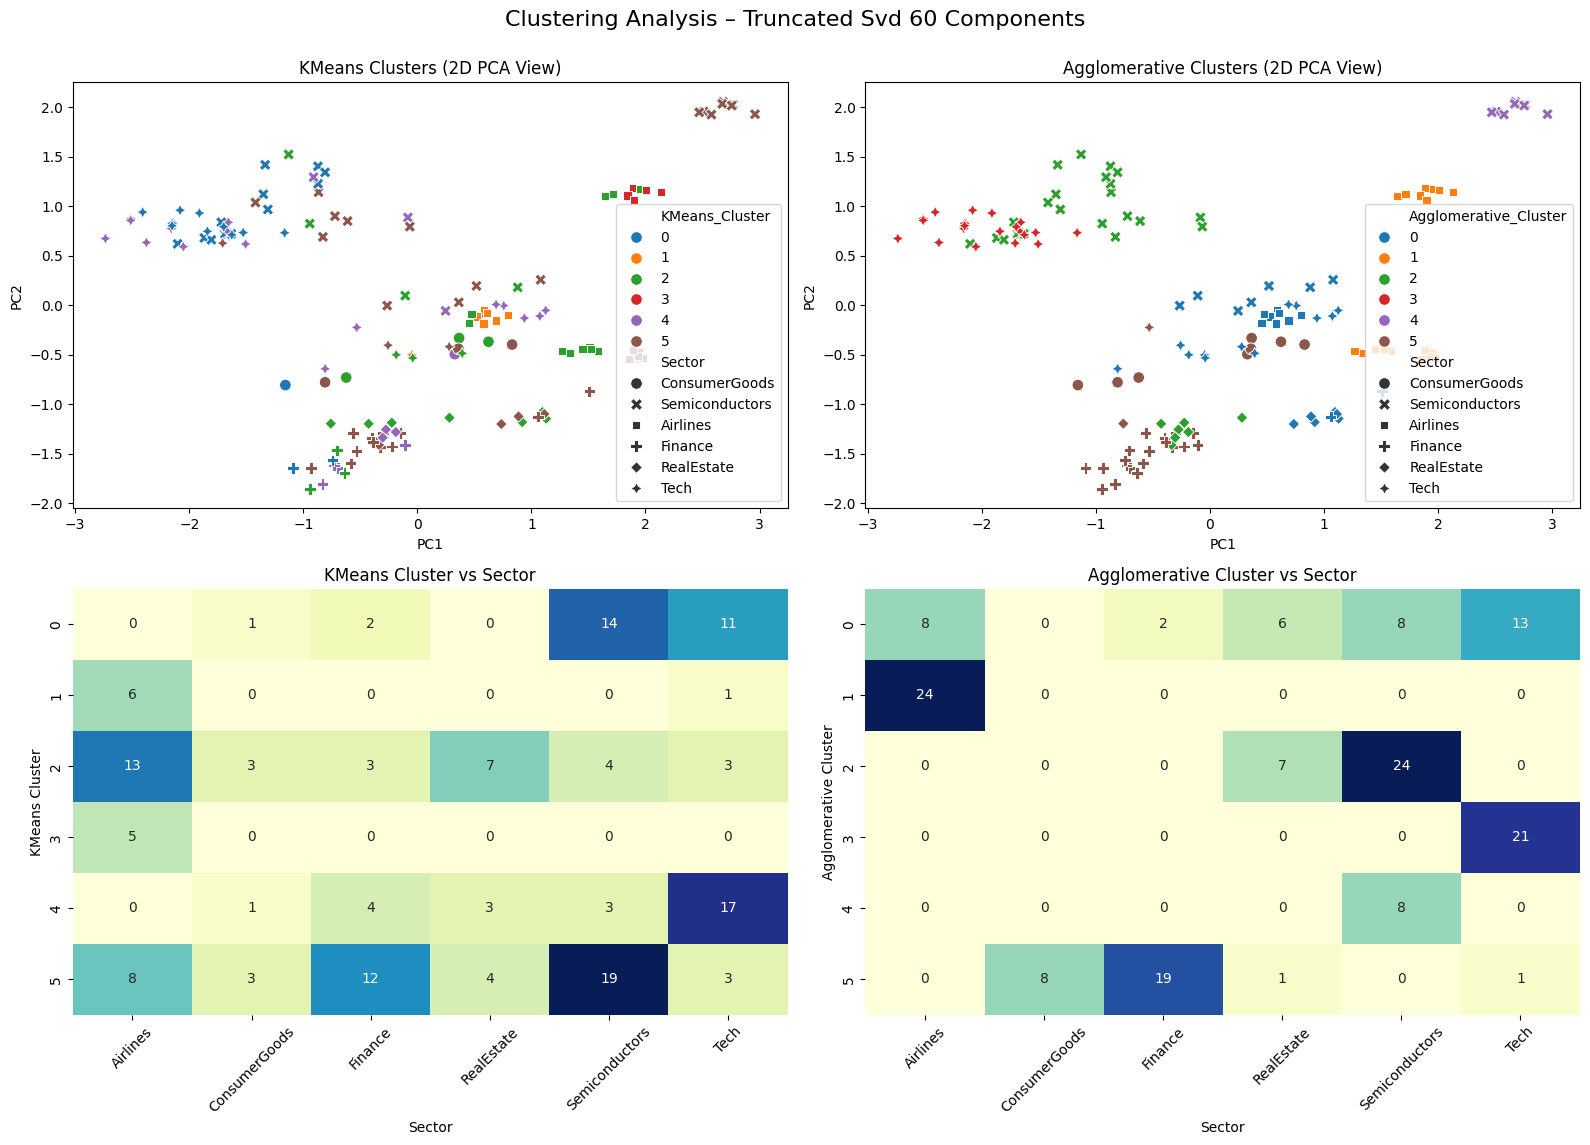

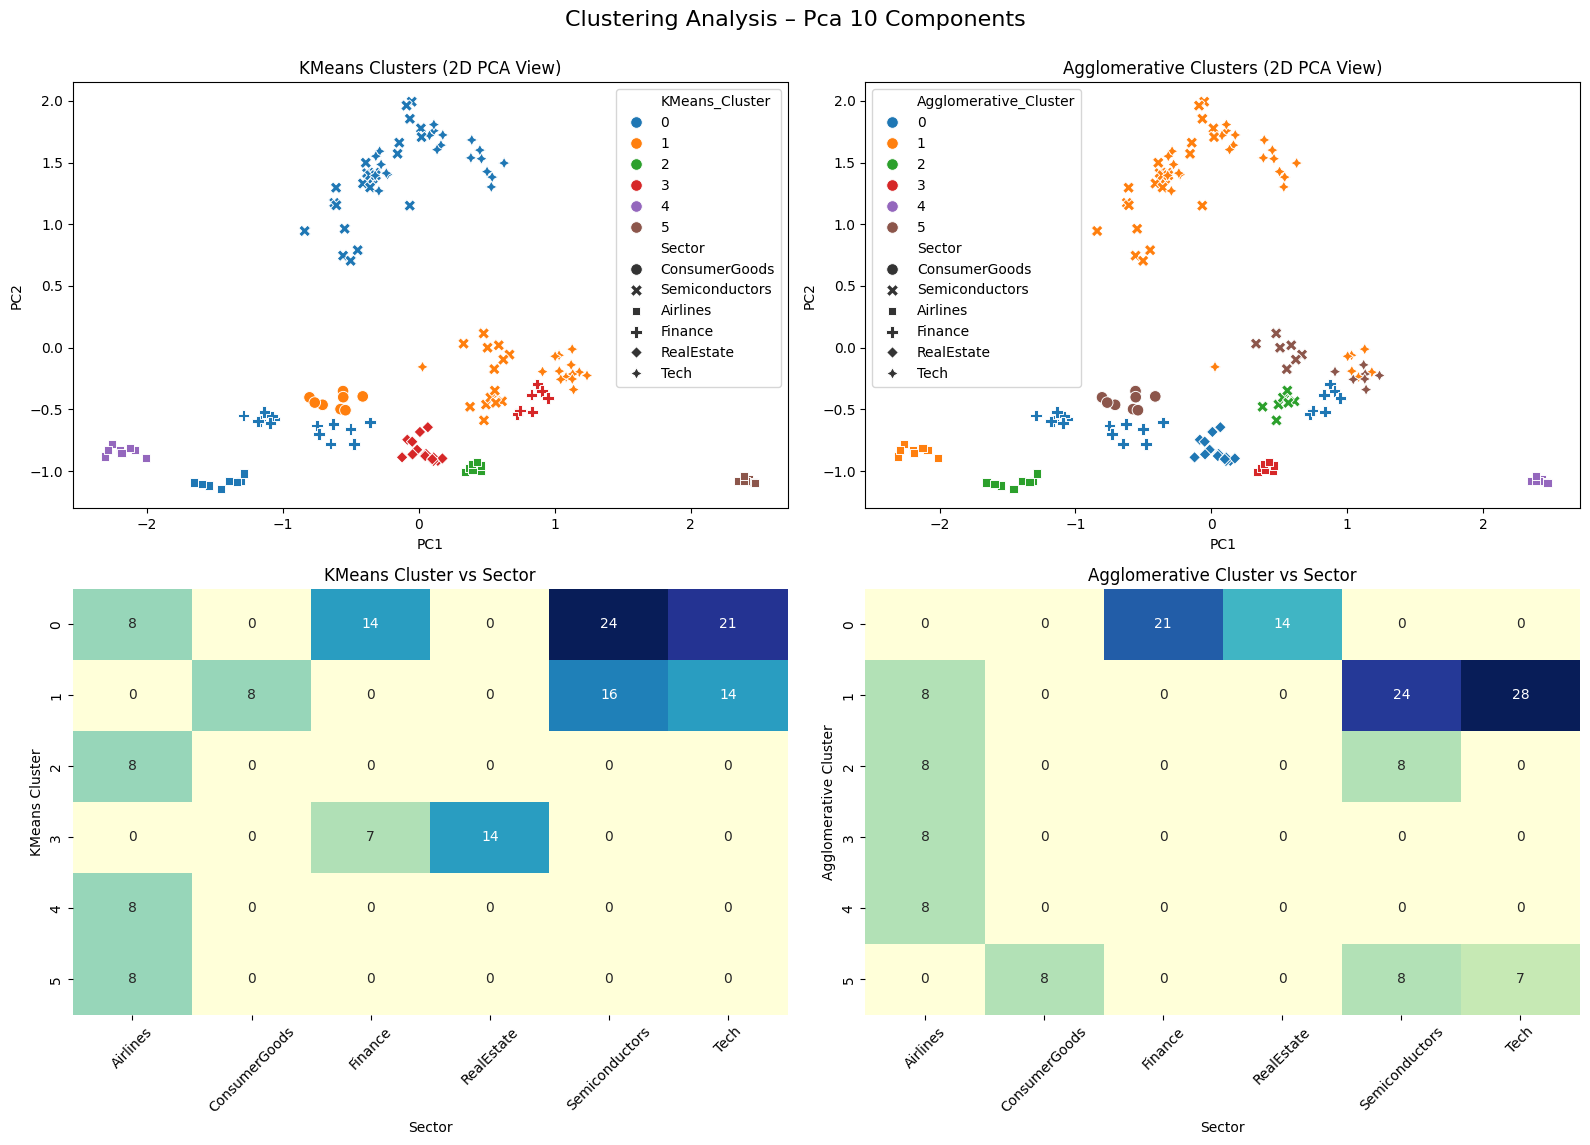

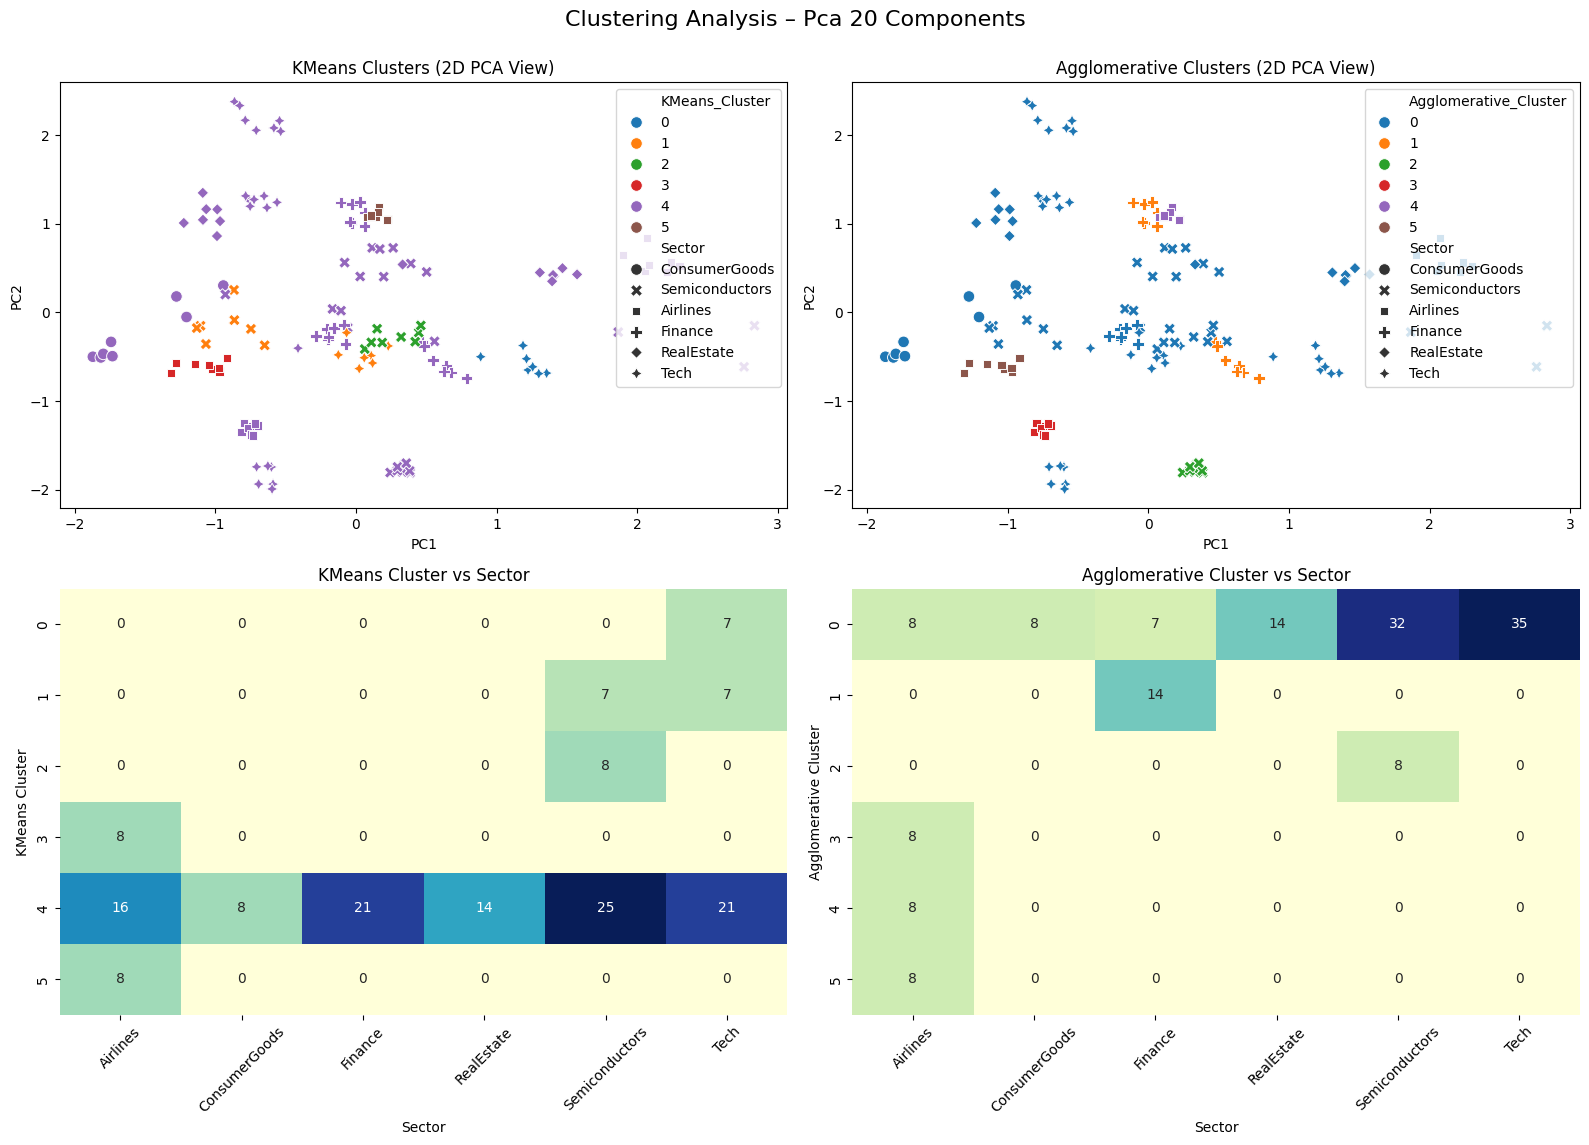

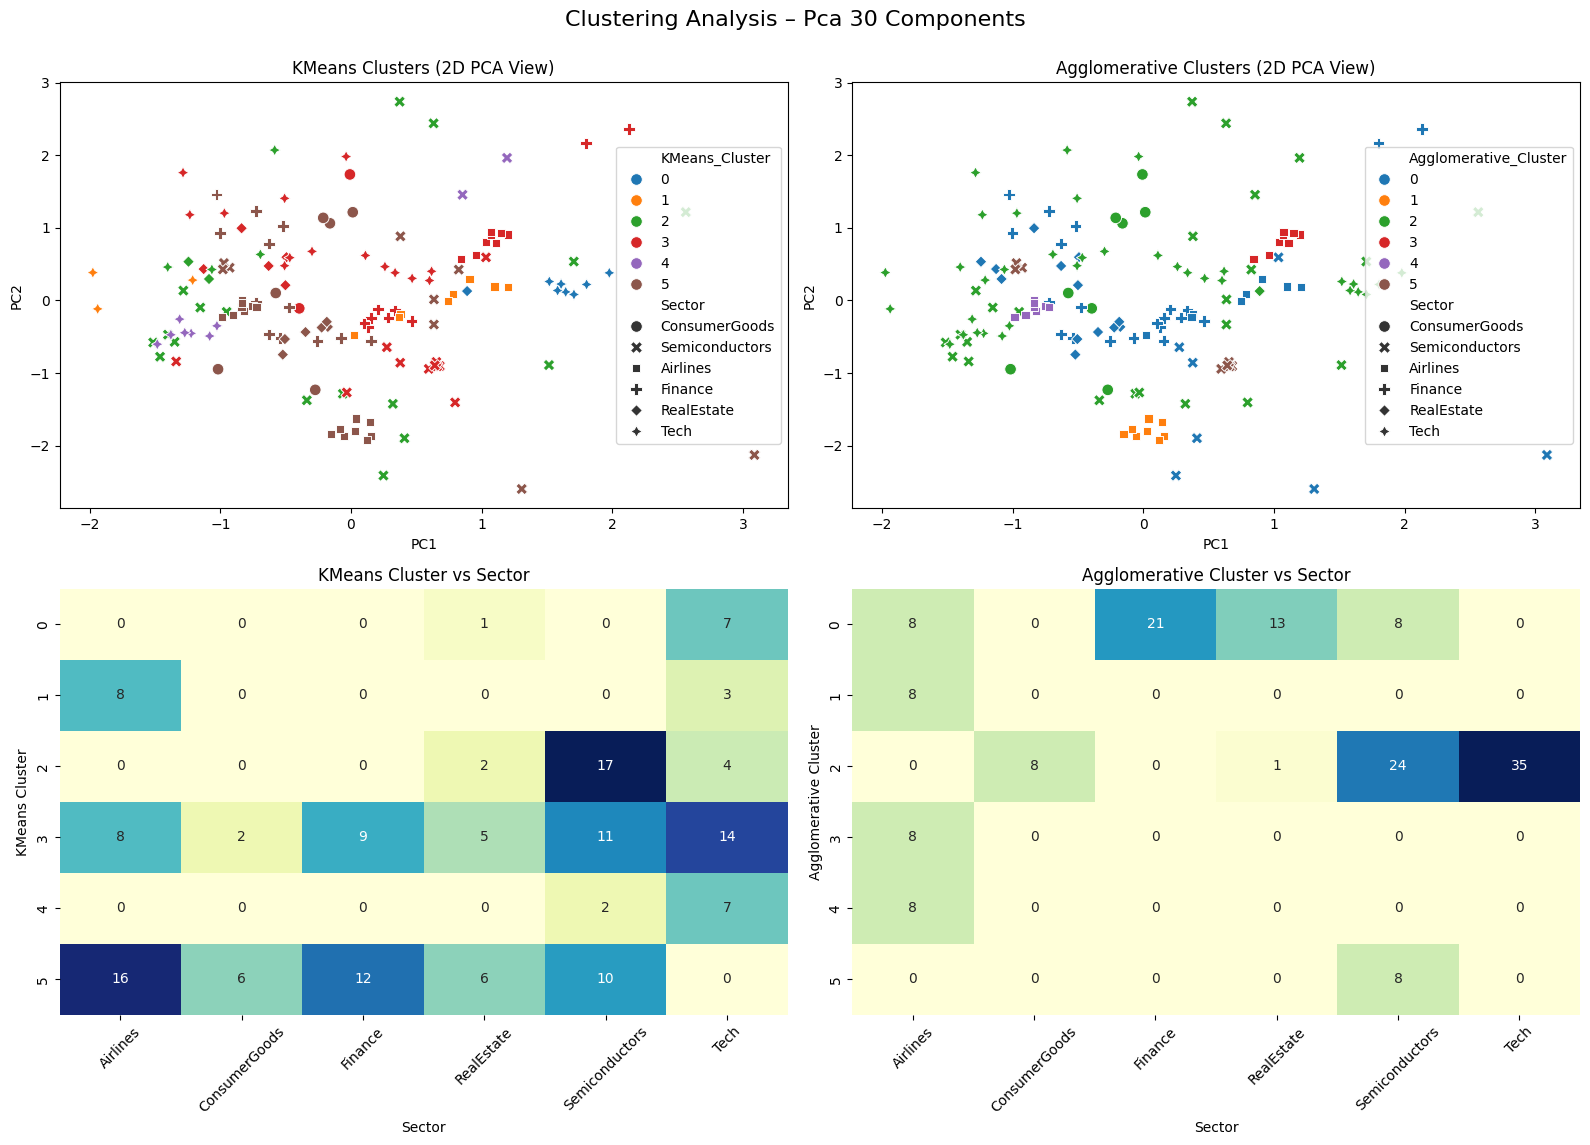

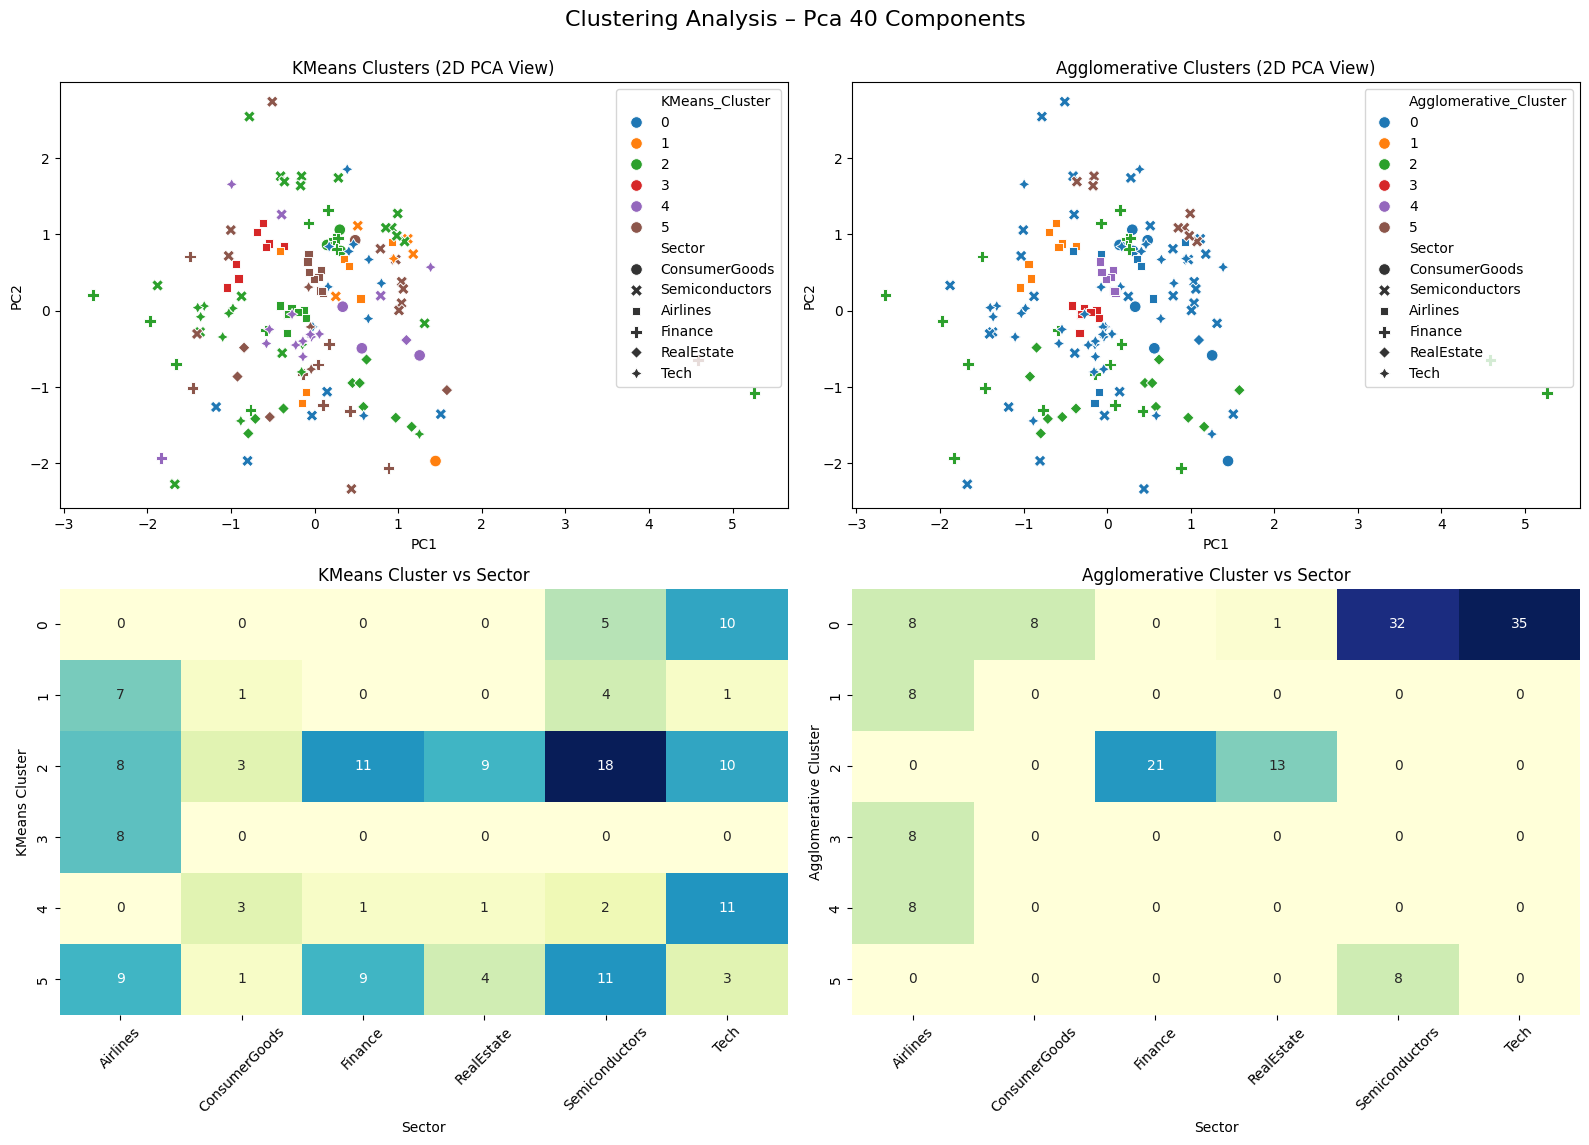

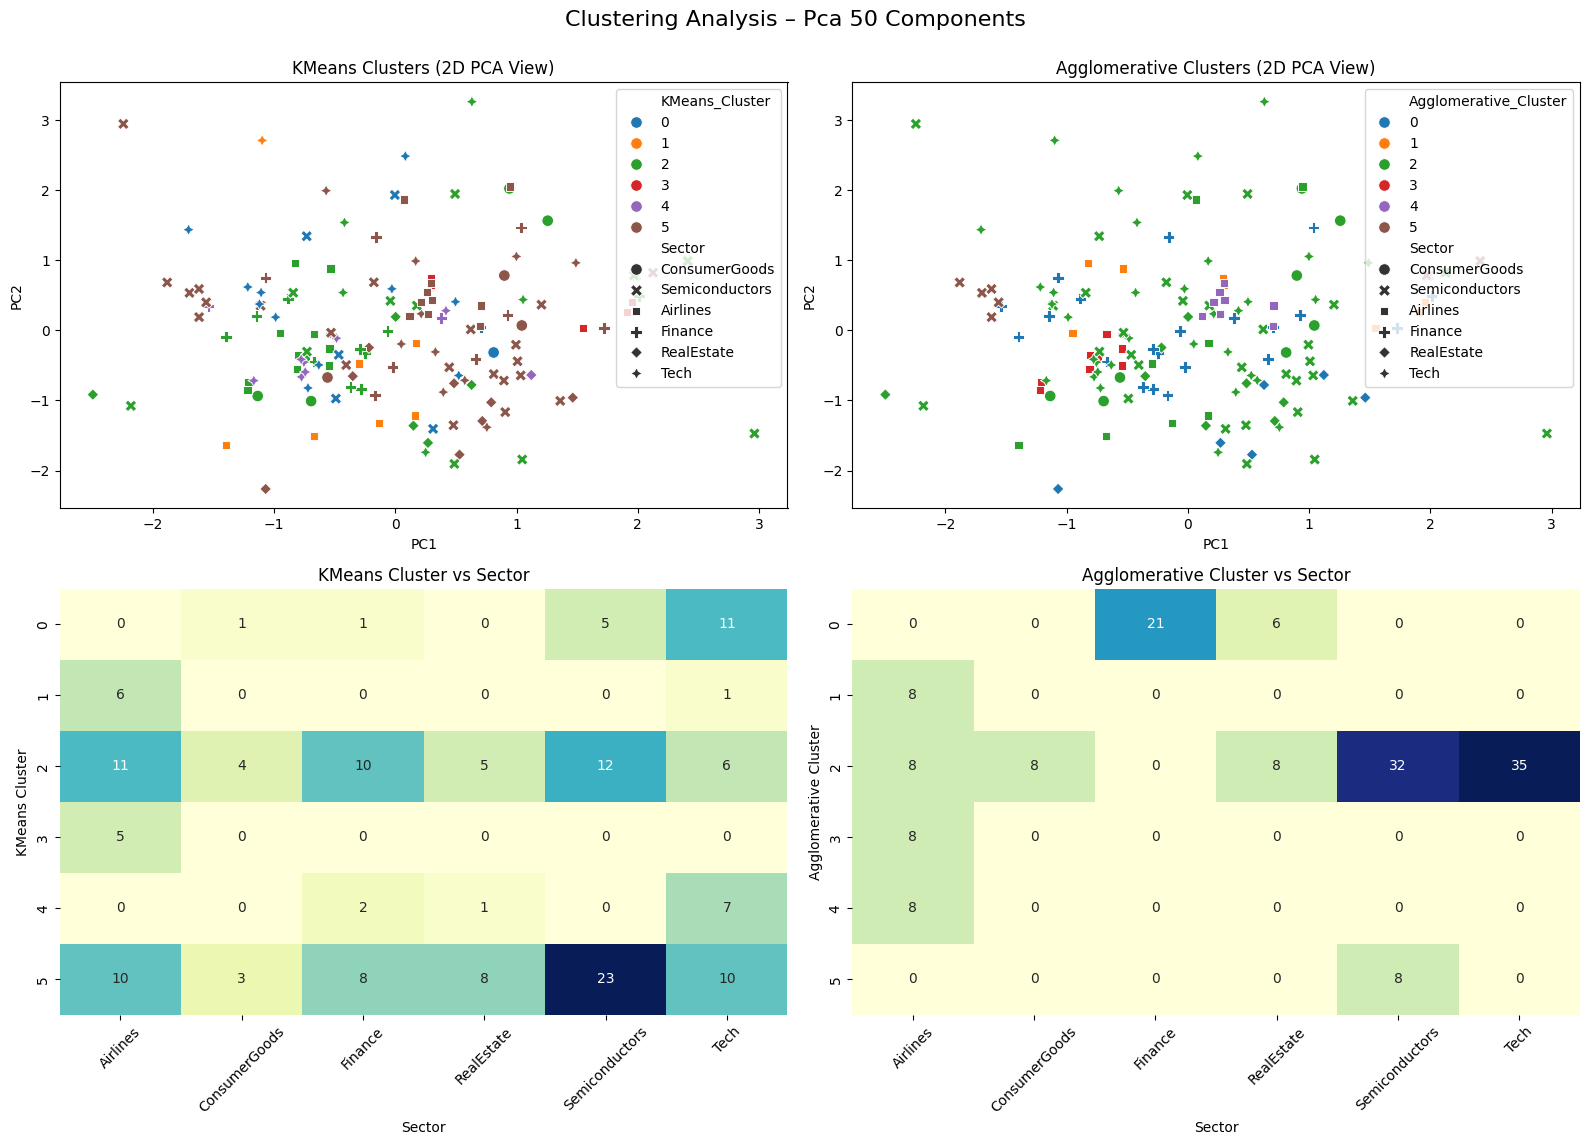

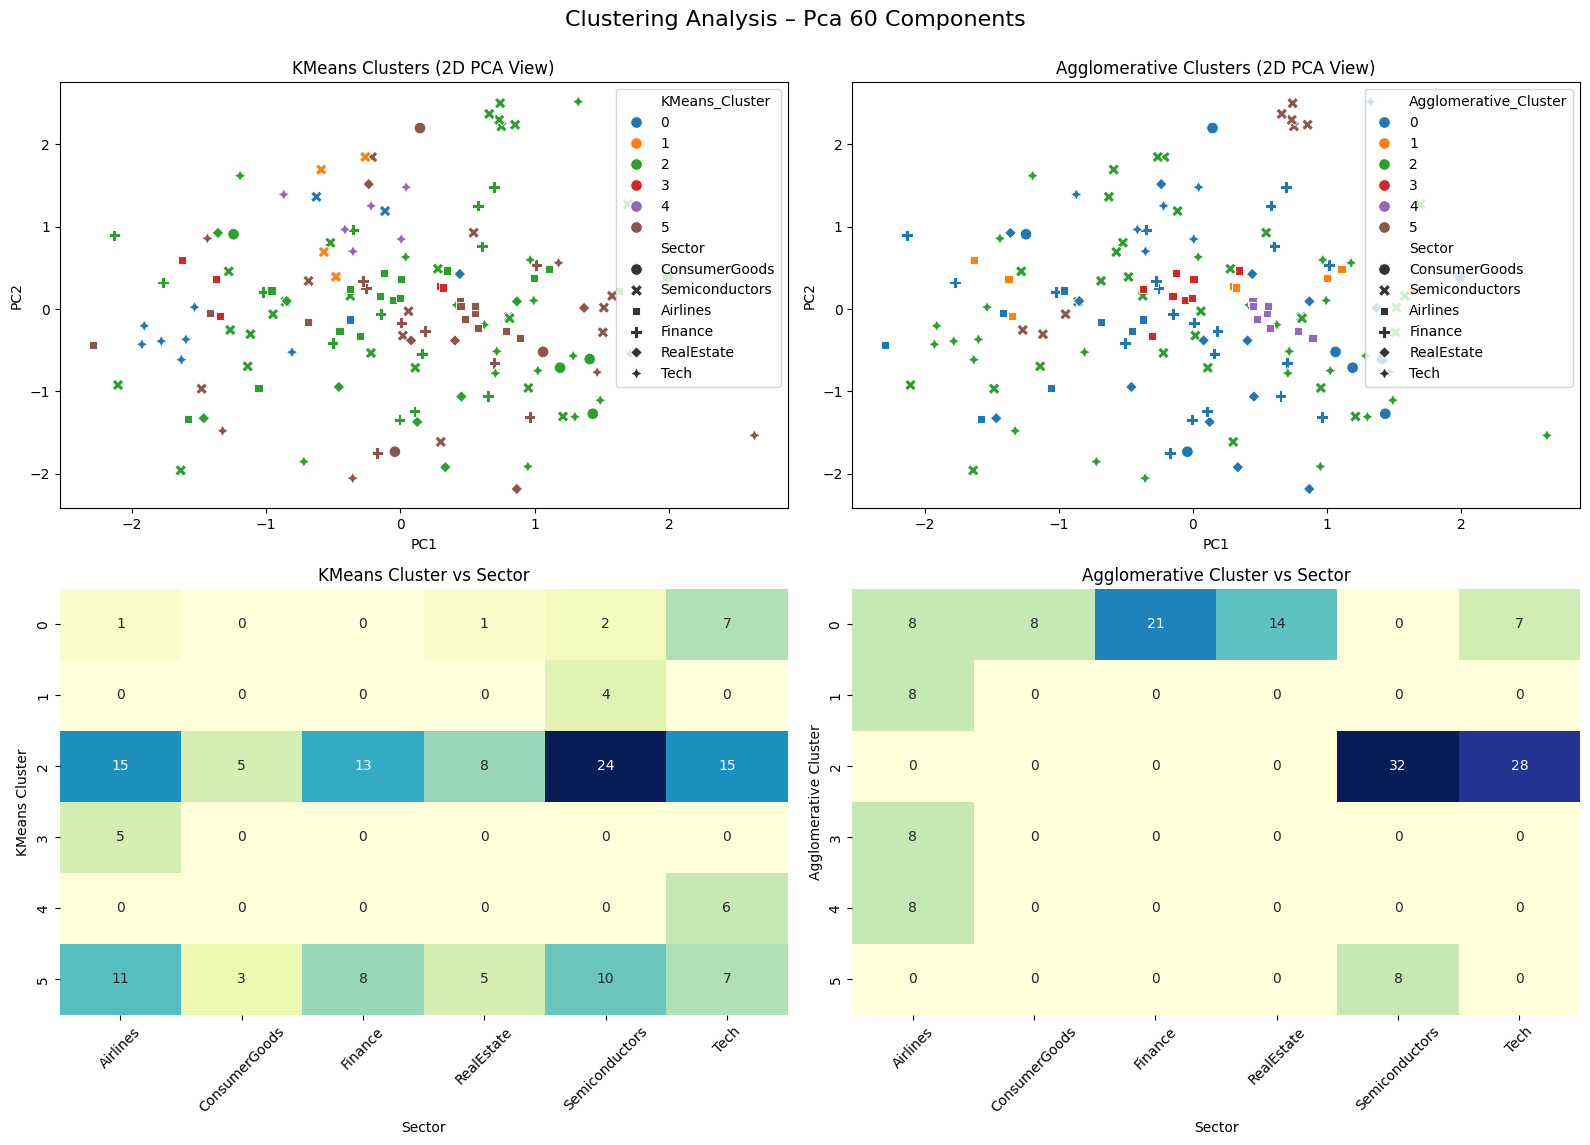

In [9]:
all_scores = []

for method in METHODS:
    df_full = pd.read_csv(DATA_PATH / f"{method}_60_components.csv")
    
    for components in NUMBER_OF_COMPONENTS:
        scores = cluster_and_visualize_from_df(df_full, method, components)
        all_scores.extend(scores)

# final score summary table
df_scores = pd.DataFrame(all_scores).sort_values(by=["Dataset", "Method"])

## Key Observations

- **Dimensionality Impact:**  
  Lower-dimensional embeddings (e.g., 10-20 components) consistently outperformed higher dimensions (30–60 components).  
  Higher component counts likely introduce noise or capture generic linguistic patterns that don't aid sector discrimination.

- **Algorithm Performance:**  
  Agglomerative clustering generally yielded higher silhouette scores than KMeans, indicating better-defined clusters.

- **Cluster-Sector Alignment:**  
  Visualizations and heatmaps show a good match between predicted clusters and true sectors (from our label). It does need to be noted that some overlap and mixing remain in certain sectors like semi-conductors (probably because semi-conductor industry is connected with a lot of these sectors like Tech, Airlines, ConsumerGoods, Finance).

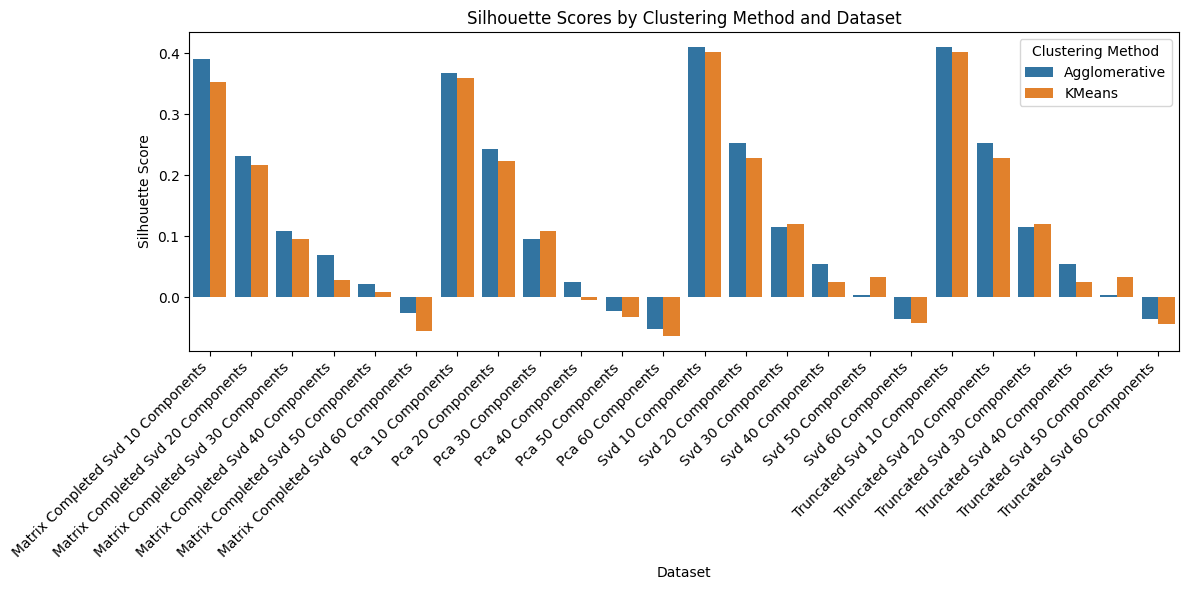

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_scores, x="Dataset", y="Silhouette Score", hue="Method")

plt.title("Silhouette Scores by Clustering Method and Dataset")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Silhouette Score")
plt.xlabel("Dataset")
plt.legend(title="Clustering Method")
plt.tight_layout()
plt.show()

# Concluding Analysis based on K-Means & Agglomerative Clustering
- Lower-dimensional embeddings capture sector-specific language variation more effectively.
- Agglomerative clustering performs better than KMeans on these datasets.
- Visual and quantitative evaluations together provide a comprehensive view of clustering performance.

---

# Hierarchical clustering

This analysis explores hierarchical clustering using different linkage methods on PCA-reduced data (10 components) across six sectors.

---

## Linkage Methods Compared

- **Ward Linkage**
- **Complete Linkage**
- **Average Linkage**
- **Single Linkage**
- **Centroid Linkage**

Silhouette score for ward linkage: 0.3683
Silhouette score for complete linkage: 0.3440
Silhouette score for average linkage: 0.4312
Silhouette score for single linkage: 0.4312
Silhouette score for centroid linkage: 0.4312


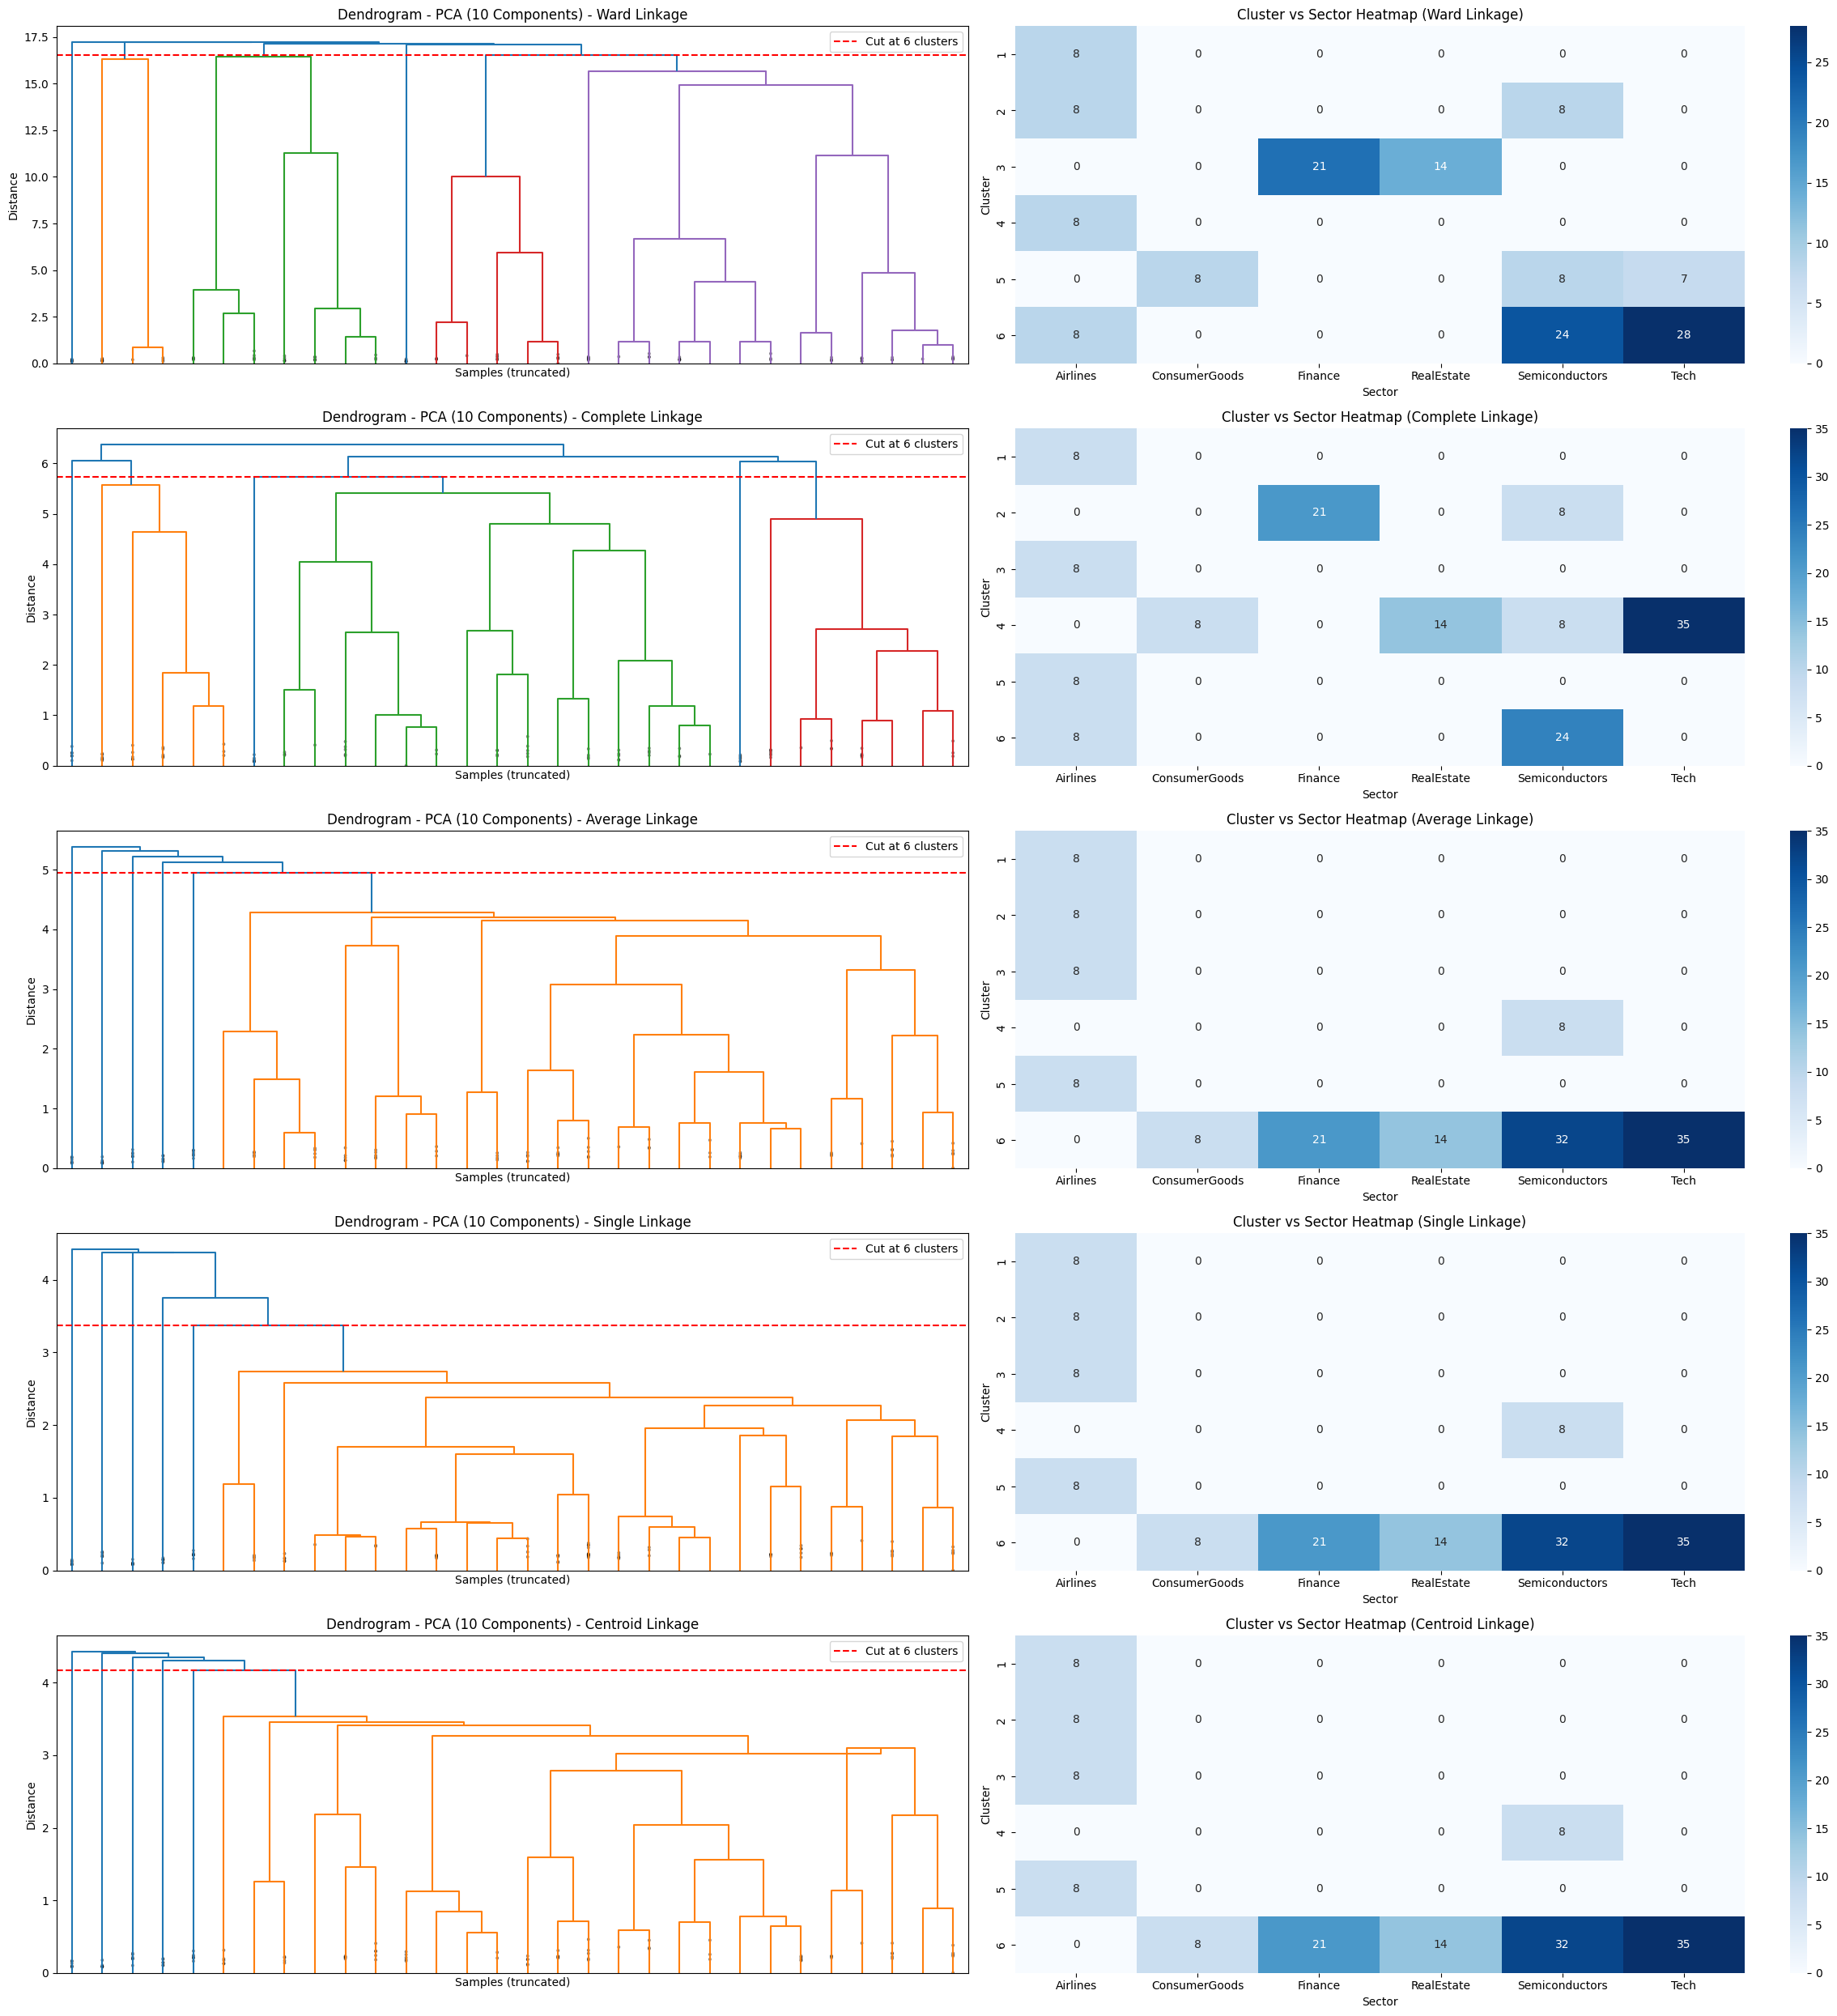

In [15]:
# --- Config ---
DATA_PATH = Path("./1000-words-kept-data/")
METHOD = "pca"
MAX_COMPONENTS = 60
USE_COMPONENTS = 10
MAX_CLUSTERS = 6
P_LEAVES = 30  # number of clusters/leaves to show in dendrogram

# --- Load Data ---
df = pd.read_csv(DATA_PATH / f"{METHOD}_{MAX_COMPONENTS}_components.csv")
feature_cols = [col for col in df.columns if col.startswith(("SVD_", "PC"))]
X = df[feature_cols[:USE_COMPONENTS]].values
labels = df["Sector"].values
identifiers = df['Company'].values if 'Company' in df.columns else df.index.astype(str).values

# --- Scale ---
X_scaled = StandardScaler().fit_transform(X)

# --- Prepare plot ---
linkage_methods = ['ward', 'complete', 'average', 'single', 'centroid']
num_methods = len(linkage_methods)

fig, axes = plt.subplots(nrows=num_methods, ncols=2, figsize=(24, num_methods * 5))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, method in enumerate(linkage_methods):
    ax_dendro = axes[i, 0]
    ax_heatmap = axes[i, 1]

    # Compute linkage matrix
    Z = linkage(X_scaled, method=method, metric='euclidean')

    # Calculate color threshold to show exactly MAX_CLUSTERS clusters
    threshold = Z[-(MAX_CLUSTERS - 1), 2]

    # Plot dendrogram with reduced leaf clutter
    dendrogram(
        Z,
        truncate_mode='lastp',   # show only last merges
        p=P_LEAVES,
        color_threshold=threshold,
        leaf_rotation=90.,
        leaf_font_size=10.,
        no_labels=True,         # hide sample names to improve readability
        show_contracted=True,
        ax=ax_dendro
    )
    ax_dendro.axhline(y=threshold, color='red', linestyle='--', label=f'Cut at {MAX_CLUSTERS} clusters')
    ax_dendro.set_title(f"Dendrogram - {METHOD.upper()} ({USE_COMPONENTS} Components) - {method.title()} Linkage")
    ax_dendro.set_xlabel("Samples (truncated)")
    ax_dendro.set_ylabel("Distance")
    ax_dendro.legend()

    # Cut dendrogram to form clusters
    clusters = fcluster(Z, t=MAX_CLUSTERS, criterion='maxclust')

    # Silhouette score
    score = silhouette_score(X_scaled, clusters, metric='euclidean')
    print(f"Silhouette score for {method} linkage: {score:.4f}")

    # Prepare contingency table for heatmap
    cluster_df = pd.DataFrame({
        'Identifier': identifiers,
        'Sector': labels,
        'Cluster': clusters
    }).sort_values(by='Cluster').reset_index(drop=True)
    contingency = pd.crosstab(cluster_df['Cluster'], cluster_df['Sector'])

    # Plot heatmap
    sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', ax=ax_heatmap)
    ax_heatmap.set_title(f"Cluster vs Sector Heatmap ({method.title()} Linkage)")
    ax_heatmap.set_xlabel("Sector")
    ax_heatmap.set_ylabel("Cluster")

plt.tight_layout()
plt.show()

## Silhouette Scores

| Linkage Method | Silhouette Score |
|----------------|------------------|
| Ward           | 0.3683           |
| Complete       | 0.3440           |
| Average        | 0.4312           |
| Single         | 0.4312           |
| Centroid       | 0.4312           |